# Chainflip Volume Analyzer

This notebook combines multiple Chainflip CSV and JSON files, cleans the data, removes duplicates, and prepares it for analysis.

**Analysis Goals:**
- Average swap size
- Percentage basis points (bps) paid
- Assets swapped by day of week
- Trending assets week-to-week
- Trending assets month-to-month


In [78]:
# Import required libraries
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

# Try to import dateutil for advanced date parsing (optional)
try:
    from dateutil import parser as date_parser
    HAS_DATEUTIL = True
except ImportError:
    HAS_DATEUTIL = False
    print("Note: dateutil not available, using basic date parsing")

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 1: Locate and Load All CSV and JSON Files

Find all `swap_transactions*` files (both CSV and JSON) in the Downloads directory and load them into a list of dataframes.



In [ ]:
# Set the directory containing data files
data_directory = Path(__file__).parent.parent / "data" if '__file__' in globals() else Path('../data').resolve()

# Find all CSV and JSON files matching the pattern
csv_files = sorted(glob.glob(str(data_directory / "swap_transactions*.csv")))
json_files = sorted(glob.glob(str(data_directory / "swap_transactions*.json")))

# Also check subdirectories (like -sep4)
csv_files.extend(sorted(glob.glob(str(data_directory / "**/swap_transactions*.csv"), recursive=True)))
json_files.extend(sorted(glob.glob(str(data_directory / "**/swap_transactions*.json"), recursive=True)))

# Remove duplicates (in case files are found multiple times)
csv_files = sorted(list(set(csv_files)))
json_files = sorted(list(set(json_files)))

# Sort files by modification time (newest first) to prioritize newer data
def get_file_mtime(file_path):
    """Get file modification time for sorting"""
    try:
        return Path(file_path).stat().st_mtime
    except:
        return 0

# Sort by modification time, newest first
all_files = csv_files + json_files
all_files = sorted(all_files, key=get_file_mtime, reverse=True)

print(f"Files sorted by modification time (newest first):")
for f in all_files[:10]:  # Show first 10
    mtime = datetime.fromtimestamp(get_file_mtime(f))
    print(f"  {Path(f).name} - Modified: {mtime.strftime('%Y-%m-%d %H:%M:%S')}")
if len(all_files) > 10:
    print(f"  ... and {len(all_files) - 10} more files")

print(f"Found {len(csv_files)} CSV files and {len(json_files)} JSON files:")
for f in csv_files:
    print(f"  CSV: {Path(f).name}")
for f in json_files:
    print(f"  JSON: {Path(f).name}")

# Load each file into a list of dataframes
dataframes = []
import json

for file_path in all_files:
    try:
        file_ext = Path(file_path).suffix.lower()
        
        if file_ext == '.csv':
            df = pd.read_csv(file_path)
        elif file_ext == '.json':
            # Load JSON file - handle both list of dicts and dict formats
            with open(file_path, 'r') as f:
                json_data = json.load(f)
            
            # If it's a list, convert to dataframe directly
            if isinstance(json_data, list):
                df = pd.json_normalize(json_data)
            # If it's a dict, try to find the data array
            elif isinstance(json_data, dict):
                # Look for common keys that might contain the data array
                if 'data' in json_data:
                    df = pd.json_normalize(json_data['data'])
                elif 'results' in json_data:
                    df = pd.json_normalize(json_data['results'])
                else:
                    # Convert single dict to dataframe
                    df = pd.DataFrame([json_data])
            else:
                print(f"⚠ Skipping {Path(file_path).name}: Unsupported JSON format")
                continue
        else:
            print(f"⚠ Skipping {Path(file_path).name}: Unknown file type")
            continue
        
        df['source_file'] = Path(file_path).name  # Track which file each row came from
        dataframes.append(df)
        print(f"✓ Loaded {len(df)} rows from {Path(file_path).name} ({file_ext})")
    except Exception as e:
        print(f"✗ Error loading {Path(file_path).name}: {e}")

print(f"\nTotal dataframes loaded: {len(dataframes)}")


Files sorted by modification time (newest first):
  swap_transactions_2025-12-02T12-59-54-865Z.csv - Modified: 2025-12-02 19:59:54
  swap_transactions_2025-12-02T12-59-46-247Z.csv - Modified: 2025-12-02 19:59:46
  swap_transactions_2025-12-02T12-59-29-460Z.csv - Modified: 2025-12-02 19:59:29
  swap_transactions_2025-12-02T12-59-16-592Z.csv - Modified: 2025-12-02 19:59:16
  swap_transactions_2025-12-02T12-59-06-994Z.csv - Modified: 2025-12-02 19:59:06
  swap_transactions_2025-12-02T12-58-58-177Z.csv - Modified: 2025-12-02 19:58:58
  swap_transactions_2025-12-02T12-58-49-065Z.csv - Modified: 2025-12-02 19:58:49
  swap_transactions_2025-12-02T12-58-41-749Z.csv - Modified: 2025-12-02 19:58:41
  swap_transactions_2025-12-02T12-56-00-715Z.csv - Modified: 2025-12-02 19:56:00
  swap_transactions_2025-12-02T12-55-47-117Z.csv - Modified: 2025-12-02 19:55:47
  ... and 67 more files
Found 77 CSV files and 0 JSON files:
  CSV: swap_transactions_2025-09-18T16-41-16-661Z.csv
  CSV: swap_transactions_

## Step 2.5: Check Data Quality Before Combining

Quick check to see data quality across different source files.


In [80]:
# Quick diagnostic: Check data quality per source file
print("=== DATA QUALITY CHECK BY SOURCE FILE ===\n")
for i, df in enumerate(dataframes):
    source = df['source_file'].iloc[0] if 'source_file' in df.columns else f"Dataframe {i}"
    print(f"\n{source}:")
    print(f"  Total rows: {len(df)}")
    
    # Check key columns
    key_cols = ['from_amount', 'to_amount', 'from_asset', 'to_asset', 'timestamp']
    for col in key_cols:
        if col in df.columns:
            non_null = df[col].notna().sum()
            pct = non_null / len(df) * 100 if len(df) > 0 else 0
            print(f"  {col}: {non_null}/{len(df)} ({pct:.1f}%)")
        else:
            print(f"  {col}: MISSING COLUMN")
    
    # Sample values to see format
    if 'from_amount' in df.columns and len(df) > 0:
        sample_val = df['from_amount'].iloc[0]
        print(f"  Sample from_amount: {repr(sample_val)} (type: {type(sample_val).__name__})")


=== DATA QUALITY CHECK BY SOURCE FILE ===


swap_transactions_2025-12-02T12-59-54-865Z.csv:
  Total rows: 6
  from_amount: MISSING COLUMN
  to_amount: MISSING COLUMN
  from_asset: MISSING COLUMN
  to_asset: MISSING COLUMN
  timestamp: MISSING COLUMN

swap_transactions_2025-12-02T12-59-46-247Z.csv:
  Total rows: 101
  from_amount: MISSING COLUMN
  to_amount: MISSING COLUMN
  from_asset: MISSING COLUMN
  to_asset: MISSING COLUMN
  timestamp: MISSING COLUMN

swap_transactions_2025-12-02T12-59-29-460Z.csv:
  Total rows: 101
  from_amount: MISSING COLUMN
  to_amount: MISSING COLUMN
  from_asset: MISSING COLUMN
  to_asset: MISSING COLUMN
  timestamp: MISSING COLUMN

swap_transactions_2025-12-02T12-59-16-592Z.csv:
  Total rows: 101
  from_amount: MISSING COLUMN
  to_amount: MISSING COLUMN
  from_asset: MISSING COLUMN
  to_asset: MISSING COLUMN
  timestamp: MISSING COLUMN

swap_transactions_2025-12-02T12-59-06-994Z.csv:
  Total rows: 101
  from_amount: MISSING COLUMN
  to_amount: MISSING COLUM

## Step 2: Combine All Dataframes

Concatenate all loaded dataframes into a single dataframe.


In [81]:
# Combine all dataframes
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Combined dataframe shape: {combined_df.shape}")
    print(f"Total rows: {len(combined_df):,}")
    print(f"Total columns: {len(combined_df.columns)}")
    print(f"\nColumns: {list(combined_df.columns)}")
else:
    print("No dataframes to combine!")


Combined dataframe shape: (4584, 18)
Total rows: 4,584
Total columns: 18

Columns: ['swap_id', 'input_currency', 'input_amount', 'input_usd_value', 'intermediate_currency', 'intermediate_amount', 'intermediate_usd_value', 'output_currency', 'output_amount', 'output_usd_value', 'sender_address', 'receiver_address', 'status', 'commission', 'age_minutes', 'age_hours', 'age_days', 'source_file']


## Step 2.5: Map Chainflip Column Names to Expected Format

Map Chainflip-specific column names to the standard format used throughout the analysis.


In [82]:
# Map Chainflip column names to expected format
# IMPORTANT: Preserve ALL original columns for traceability and verification
# We add mapped columns alongside originals, never drop original data
print("Mapping Chainflip columns to expected format...")
print(f"Original columns: {list(combined_df.columns)}")

# Column mapping: Chainflip -> Expected format
# We create NEW columns with mapped names, but KEEP original columns
column_mapping = {
    'swap_id': 'tx_hash',  # Keep swap_id for traceability
    'input_currency': 'from_asset',  # Keep input_currency
    'input_amount': 'from_amount',  # Keep input_amount
    'input_usd_value': 'from_amount_usd',  # Keep input_usd_value
    'output_currency': 'to_asset',  # Keep output_currency
    'output_amount': 'to_amount',  # Keep output_amount
    'output_usd_value': 'to_amount_usd',  # Keep output_usd_value
    'sender_address': 'from_address',  # Keep sender_address (contains hyperlinks!)
    'receiver_address': 'to_address',  # Keep receiver_address (contains hyperlinks!)
    'commission': 'fee_usd',  # Keep commission
    'status': 'status',  # Keep status
    # Keep intermediate columns if they exist
    'intermediate_currency': 'intermediate_currency',
    'intermediate_amount': 'intermediate_amount',
    'intermediate_usd_value': 'intermediate_usd_value',
    # Age columns from Swap Table Scanner v3
    'age_minutes': 'age_minutes',
    'age_hours': 'age_hours',
    'age_days': 'age_days',
}

# Apply mapping: Create new columns but PRESERVE all original columns
# This ensures full traceability - you can always verify using original swap_id, hyperlinks, etc.
mapped_columns = {}
for old_col, new_col in column_mapping.items():
    if old_col in combined_df.columns:
        # Only create new column if it doesn't already exist or if names differ
        if old_col != new_col:
            combined_df[new_col] = combined_df[old_col]
            mapped_columns[old_col] = new_col
            print(f"  ✓ Created '{new_col}' from '{old_col}' (original '{old_col}' preserved)")
        else:
            # Column name unchanged, no mapping needed
            mapped_columns[old_col] = new_col
    else:
        print(f"  ⚠ Column '{old_col}' not found in data")

print(f"\n✓ Column mapping complete - ALL original columns preserved for traceability!")

# Handle timestamp - check if it exists, if not try to create from other columns
if 'timestamp' not in combined_df.columns:
    # Check for common timestamp column names
    timestamp_cols = ['timestamp', 'created_at', 'date', 'time', 'block_time', 'transaction_time']
    found_timestamp = False
    for ts_col in timestamp_cols:
        if ts_col in combined_df.columns:
            combined_df['timestamp'] = pd.to_datetime(combined_df[ts_col], errors='coerce')
            found_timestamp = True
            print(f"  Using '{ts_col}' as timestamp")
            break
    
    if not found_timestamp:
        print("  ⚠ Warning: No timestamp column found. Analysis may be limited.")
        # Create a dummy timestamp if needed (using current time or index)
        combined_df['timestamp'] = pd.NaT

# Ensure age columns exist (initialize with 0 if missing)
# These columns come from Swap Table Scanner v3 age extraction
age_columns = ['age_minutes', 'age_hours', 'age_days']
for age_col in age_columns:
    if age_col not in combined_df.columns:
        combined_df[age_col] = 0
        print(f"  ✓ Added missing age column: '{age_col}' (initialized to 0)")
    else:
        # Ensure numeric type and fill NaN with 0
        combined_df[age_col] = pd.to_numeric(combined_df[age_col], errors='coerce').fillna(0)
        print(f"  ✓ Found age column: '{age_col}'")

# Handle user_address - use sender_address if available
if 'user_address' not in combined_df.columns:
    if 'from_address' in combined_df.columns:
        combined_df['user_address'] = combined_df['from_address']
    elif 'sender_address' in combined_df.columns:
        combined_df['user_address'] = combined_df['sender_address']

# IMPORTANT: Keep from_amount/to_amount (raw token amounts) separate from from_amount_usd/to_amount_usd (USD values)
# DO NOT overwrite raw amounts with USD values - they serve different purposes:
# - from_amount: Raw token amount (e.g., 0.02375325 BTC)
# - from_amount_usd: USD value of that amount (e.g., 2052.782)
# Both columns should exist and remain separate for accurate analysis

# Ensure fee_usd exists - use commission if available, but validate it's reasonable
if 'fee_usd' not in combined_df.columns or combined_df['fee_usd'].isna().all():
    if 'commission' in combined_df.columns:
        commission_raw = pd.to_numeric(combined_df['commission'], errors='coerce')
        from_amount_usd = combined_df.get('from_amount_usd', pd.Series())
        
        # Validate commission: it should be a reasonable percentage of the swap amount
        # If commission > 10% of swap amount, it's likely incorrect (might be the swap amount itself)
        # Cap commission at 10% of swap amount, or use 0.3% estimate if commission seems wrong
        max_reasonable_fee_pct = 0.10  # 10% maximum reasonable fee
        
        # Calculate what the commission should be if it's a percentage
        reasonable_fee = from_amount_usd * max_reasonable_fee_pct
        
        # Initialize fee_usd with estimated fee
        combined_df['fee_usd'] = from_amount_usd * 0.003
        
        # Use commission if it's reasonable (< 10% of swap and > 0)
        reasonable_mask = (commission_raw.notna()) & (commission_raw > 0) & (commission_raw <= reasonable_fee)
        combined_df.loc[reasonable_mask, 'fee_usd'] = commission_raw[reasonable_mask]
        
        # Count how many commissions were rejected
        rejected_count = ((commission_raw.notna()) & (commission_raw > reasonable_fee)).sum()
        if rejected_count > 0:
            print(f"  ⚠ Warning: {rejected_count} commission values were too large (>10% of swap) and replaced with 0.3% estimate")
    else:
        # Estimate fee if not available (0.3% of input)
        combined_df['fee_usd'] = combined_df.get('from_amount_usd', pd.Series()) * 0.003

# Create type column if missing (assume all are swaps)
if 'type' not in combined_df.columns:
    combined_df['type'] = 'Swap'

print(f"\n✓ Column mapping complete!")
print(f"Mapped columns: {mapped_columns}")
print(f"\nFinal columns: {list(combined_df.columns)}")
print(f"\nData shape: {combined_df.shape}")

# Display traceability columns for verification
print(f"\n{'='*80}")
print("TRACEABILITY COLUMNS - All original data preserved for verification:")
print(f"{'='*80}")
traceability_cols = ['swap_id', 'tx_hash', 'sender_address', 'receiver_address', 'from_address', 'to_address', 'source_file']
available_trace = [col for col in traceability_cols if col in combined_df.columns]
print(f"Available traceability columns: {available_trace}")
print(f"\nSample showing traceability (first 3 rows):")
if available_trace:
    print(combined_df[available_trace].head(3).to_string())
    
print(f"\n{'='*80}")
print("KEY ANALYSIS COLUMNS:")
print(f"{'='*80}")
key_cols = ['tx_hash', 'swap_id', 'from_asset', 'from_amount', 'from_amount_usd', 'to_asset', 'to_amount', 'to_amount_usd', 'fee_usd', 'timestamp', 'status', 'source_file']
available_cols = [col for col in key_cols if col in combined_df.columns]
print(combined_df[available_cols].head(5))


Mapping Chainflip columns to expected format...
Original columns: ['swap_id', 'input_currency', 'input_amount', 'input_usd_value', 'intermediate_currency', 'intermediate_amount', 'intermediate_usd_value', 'output_currency', 'output_amount', 'output_usd_value', 'sender_address', 'receiver_address', 'status', 'commission', 'age_minutes', 'age_hours', 'age_days', 'source_file']
  ⚠ Warning: No timestamp column found. Analysis may be limited.
  ✓ Found age column: 'age_minutes'
  ✓ Found age column: 'age_hours'
  ✓ Found age column: 'age_days'

✓ Column mapping complete!
Mapped columns: {'swap_id': 'tx_hash', 'input_currency': 'from_asset', 'input_amount': 'from_amount', 'input_usd_value': 'from_amount_usd', 'output_currency': 'to_asset', 'output_amount': 'to_amount', 'output_usd_value': 'to_amount_usd', 'sender_address': 'from_address', 'receiver_address': 'to_address', 'commission': 'fee_usd', 'status': 'status', 'intermediate_currency': 'intermediate_currency', 'intermediate_amount': 'i

## Data Traceability & Verification

**All original data is preserved for full traceability and verification.**

### Traceability Columns

Every row can be verified using these preserved columns:

1. **`swap_id`** - Original unique swap identifier from Chainflip (e.g., `#10666975`)
2. **`tx_hash`** - Mapped version of swap_id (same value, different name for compatibility)
3. **`sender_address`** - Original sender address with hyperlink (e.g., `https://etherscan.io/address/0x...`)
4. **`receiver_address`** - Original receiver address with hyperlink (e.g., `https://mempool.space/address/...`)
5. **`from_address`** - Mapped version of sender_address
6. **`to_address`** - Mapped version of receiver_address
7. **`source_file`** - Original CSV/JSON file name where this data came from

### Original vs Mapped Columns

**All original columns are preserved alongside mapped versions:**

- `swap_id` + `tx_hash` (both kept)
- `input_currency` + `from_asset` (both kept)
- `input_amount` + `from_amount` (both kept)
- `input_usd_value` + `from_amount_usd` (both kept)
- `output_currency` + `to_asset` (both kept)
- `output_amount` + `to_amount` (both kept)
- `output_usd_value` + `to_amount_usd` (both kept)
- `sender_address` + `from_address` (both kept - **hyperlinks preserved!**)
- `receiver_address` + `to_address` (both kept - **hyperlinks preserved!**)
- `commission` + `fee_usd` (both kept)

### How to Verify Data

1. **By Swap ID**: Use `swap_id` to look up the original transaction
2. **By Hyperlink**: Click `sender_address` or `receiver_address` to view on blockchain explorer
3. **By Source File**: Use `source_file` to find the original CSV/JSON file
4. **Cross-reference**: Compare original columns (`input_amount`) with mapped columns (`from_amount`) to verify calculations

### Example Verification

```python
# Find a specific swap by ID
swap = combined_df[combined_df['swap_id'] == '#10666975']

# Verify amounts match
print(f"Original input_amount: {swap['input_amount'].values[0]}")
print(f"Mapped from_amount: {swap['from_amount'].values[0]}")
print(f"USD value: {swap['from_amount_usd'].values[0]}")
print(f"Source file: {swap['source_file'].values[0]}")
print(f"Sender link: {swap['sender_address'].values[0]}")
```

**No data is ever dropped - everything is preserved for audit and verification purposes.**

## Step 3: Remove Duplicates

Identify and remove duplicate rows based on transaction hash (tx_hash), which should be unique for each swap.




In [83]:
# Check for duplicates based on tx_hash
initial_count = len(combined_df)
print(f"Initial row count: {initial_count:,}")

# Count duplicates
duplicate_count = combined_df.duplicated(subset=['tx_hash'], keep=False).sum()
print(f"Rows with duplicate tx_hash: {duplicate_count:,}")

# Remove duplicates, keeping the FIRST occurrence (newer files loaded first)
# This prioritizes newer data over older data since files are sorted by modification time (newest first)
combined_df = combined_df.drop_duplicates(subset=['tx_hash'], keep='first')

final_count = len(combined_df)
removed_count = initial_count - final_count
print(f"\nRemoved {removed_count:,} duplicate rows")
print(f"Final row count: {final_count:,}")
print(f"Duplicate removal rate: {removed_count/initial_count*100:.2f}%")
print("\n✓ Kept newer entries when duplicates found (newer files have priority)")


Initial row count: 4,584
Rows with duplicate tx_hash: 2,641

Removed 1,936 duplicate rows
Final row count: 2,648
Duplicate removal rate: 42.23%

✓ Kept newer entries when duplicates found (newer files have priority)


## Step 4.5: Parse Missing Data from raw_row_text

Some entries have missing `from_amount`, `to_amount`, `from_asset`, or `to_asset` in the JSON, but the data exists in `raw_row_text`. Parse it to fill in missing values.



In [84]:
# Skip raw_row_text parsing if column doesn't exist (Chainflip data may not have this)
if 'raw_row_text' in combined_df.columns:
    # Parse raw_row_text to extract missing from_amount, to_amount, from_asset, to_asset
    # Pattern: \t\nSwap\n\t\n{from_amount}\n{from_asset}\n{to_amount}\n{to_asset}
    # Pattern for Add: \t\nAdd\n\t\n{amount}\n{asset}\n{to_asset}
    
    def parse_raw_row_text(row):
        """Parse raw_row_text to extract missing swap/transaction data"""
        # Create a copy to avoid issues with pandas
        row = row.copy()
        
        if 'raw_row_text' not in row.index or pd.isna(row.get('raw_row_text')):
            return row
        
        raw_text = str(row.get('raw_row_text', ''))
        
        # Check if we need to fill missing values
        needs_from_amount = pd.isna(row.get('from_amount')) or str(row.get('from_amount', '')).strip() == ''
        needs_to_amount = pd.isna(row.get('to_amount')) or str(row.get('to_amount', '')).strip() == ''
        needs_from_asset = pd.isna(row.get('from_asset')) or str(row.get('from_asset', '')).strip() == ''
        needs_to_asset = pd.isna(row.get('to_asset')) or str(row.get('to_asset', '')).strip() == ''
        
        if not (needs_from_amount or needs_to_amount or needs_from_asset or needs_to_asset):
            return row  # Nothing to parse
        
        # Try to parse Swap pattern: \t\nSwap\n\t\n{from_amount}\n{from_asset}\n{to_amount}\n{to_asset}
        swap_pattern = r'\t\nSwap\n\t\n([^\n]+)\n([^\n]+)\n([^\n]+)\n([^\n]+)'
        swap_match = re.search(swap_pattern, raw_text)
        
        if swap_match:
            from_amount_str, from_asset_str, to_amount_str, to_asset_str = swap_match.groups()
            
            if needs_from_amount:
                row['from_amount'] = from_amount_str.strip()
            if needs_from_asset:
                row['from_asset'] = from_asset_str.strip()
            if needs_to_amount:
                row['to_amount'] = to_amount_str.strip()
            if needs_to_asset:
                row['to_asset'] = to_asset_str.strip()
            
            return row
        
        # Try to parse Add pattern: \t\nAdd\n\t\n{amount}\n{asset}\n{to_asset}
        add_pattern = r'\t\nAdd\n\t\n([^\n]+)\n([^\n]+)\n([^\n]+)'
        add_match = re.search(add_pattern, raw_text)
        
        if add_match:
            amount_str, asset_str, to_asset_str = add_match.groups()
            
            # For Add transactions, we might not have a clear from/to distinction
            # But we can try to fill what's missing
            if needs_from_amount:
                row['from_amount'] = amount_str.strip()
            if needs_from_asset:
                row['from_asset'] = asset_str.strip()
            if needs_to_asset:
                row['to_asset'] = to_asset_str.strip()
            # For Add transactions, set to_amount to 0 since it's a liquidity addition, not a swap
            if needs_to_amount:
                row['to_amount'] = '0'
            
            return row
        
        return row
    
    # Apply parsing to rows with missing data
    print("Parsing raw_row_text to fill missing values...")
    missing_before = (
        combined_df['from_amount'].isna() | 
        combined_df['to_amount'].isna() | 
        combined_df['from_asset'].isna() | 
        combined_df['to_asset'].isna()
    ).sum()
    
    # Apply parsing function row by row - use apply which returns a DataFrame
    combined_df = combined_df.apply(parse_raw_row_text, axis=1)
    
    missing_after = (
        combined_df['from_amount'].isna() | 
        combined_df['to_amount'].isna() | 
        combined_df['from_asset'].isna() | 
        combined_df['to_asset'].isna()
    ).sum()
    
    filled_count = missing_before - missing_after
    print(f"✓ Filled {filled_count} missing values from raw_row_text")
    print(f"  Missing before: {missing_before}, Missing after: {missing_after}")
    
    # Now re-apply cleaning functions since we may have added string values
    # Clean numeric strings again (in case we parsed comma-separated numbers)
    if 'from_amount' in combined_df.columns:
        combined_df['from_amount'] = combined_df['from_amount'].apply(clean_numeric_string)
        combined_df['from_amount'] = pd.to_numeric(combined_df['from_amount'], errors='coerce')
    
    if 'to_amount' in combined_df.columns:
        combined_df['to_amount'] = combined_df['to_amount'].apply(clean_numeric_string)
        combined_df['to_amount'] = pd.to_numeric(combined_df['to_amount'], errors='coerce')
    
    # Clean asset names again
    if 'from_asset' in combined_df.columns:
        combined_df['from_asset'] = combined_df['from_asset'].apply(clean_asset_name)
    
    if 'to_asset' in combined_df.columns:
        combined_df['to_asset'] = combined_df['to_asset'].apply(clean_asset_name)
    
    # For Add transactions (liquidity additions), set to_amount to 0 if still missing
    # Add transactions don't have a to_amount in the raw data since they're not swaps
    if 'type' in combined_df.columns and 'to_amount' in combined_df.columns:
        add_mask = (combined_df['type'] == 'Add') & (combined_df['to_amount'].isna())
        add_count = add_mask.sum()
        if add_count > 0:
            combined_df.loc[add_mask, 'to_amount'] = 0
            print(f"✓ Set to_amount=0 for {add_count} Add transactions (liquidity additions)")
    
    print(f"✓ Re-cleaned parsed values")
    print(f"  Final missing from_amount: {combined_df['from_amount'].isna().sum()}")
    print(f"  Final missing to_amount: {combined_df['to_amount'].isna().sum()}")
    print(f"  Final missing from_asset: {combined_df['from_asset'].isna().sum()}")
    print(f"  Final missing to_asset: {combined_df['to_asset'].isna().sum()}")
    

else:
    print('Skipping raw_row_text parsing - column not found in Chainflip data')
    print('Chainflip data should have all fields populated directly')


Skipping raw_row_text parsing - column not found in Chainflip data
Chainflip data should have all fields populated directly


## Step 4: Clean and Standardize Data

Clean up the data for human readability:
- Convert timestamps to datetime
- Ensure numeric columns are properly typed
- Clean up asset names
- Calculate swap size and basis points




In [85]:
# Convert timestamp to datetime
# Handle custom format: "Sep 18 2025 04:15:38 AM (GMT-7)"
if 'timestamp' in combined_df.columns:
    def parse_custom_timestamp(ts):
        """Parse custom timestamp format: 'Sep 18 2025 04:15:38 AM (GMT-7)'"""
        if pd.isna(ts) or ts == '' or str(ts).strip() == '':
            return pd.NaT
        
        ts_str = str(ts).strip()
        
        # Try standard pandas parsing first
        result = pd.to_datetime(ts_str, errors='coerce')
        if pd.notna(result):
            return result
        
        # Handle custom format: "Sep 18 2025 04:15:38 AM (GMT-7)"
        # Remove timezone info in parentheses
        ts_clean = re.sub(r'\s*\([^)]+\)\s*$', '', ts_str).strip()
        
        # Try with dateutil if available (more flexible)
        if HAS_DATEUTIL:
            try:
                return pd.to_datetime(date_parser.parse(ts_clean))
            except:
                pass
        
        # Fallback: try pandas with cleaned string
        result = pd.to_datetime(ts_clean, errors='coerce')
        if pd.notna(result):
            return result
        
        # Last resort: try to manually parse "Sep 18 2025 04:15:38 AM" format
        try:
            # Pattern: "Sep 18 2025 04:15:38 AM"
            match = re.match(r'(\w+)\s+(\d+)\s+(\d+)\s+(\d+):(\d+):(\d+)\s+(AM|PM)', ts_clean, re.IGNORECASE)
            if match:
                month_str, day, year, hour, minute, second, am_pm = match.groups()
                # Convert month abbreviation to number
                months = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                         'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
                month = months.get(month_str.lower()[:3])
                if month:
                    # Convert 12-hour to 24-hour format
                    hour = int(hour)
                    if am_pm.upper() == 'PM' and hour != 12:
                        hour += 12
                    elif am_pm.upper() == 'AM' and hour == 12:
                        hour = 0
                    return pd.Timestamp(int(year), month, int(day), int(hour), int(minute), int(second))
        except:
            pass
        
        return pd.NaT
    
    # Apply custom parsing
    combined_df['timestamp'] = combined_df['timestamp'].apply(parse_custom_timestamp)
    
    # Count successful conversions
    successful = combined_df['timestamp'].notna().sum()
    total = len(combined_df)
    print(f"✓ Converted timestamp to datetime ({successful}/{total} successful, {successful/total*100:.1f}%)")

# Ensure numeric columns are properly typed
# Handle comma-separated numbers (common in JSON files)
def clean_numeric_string(val):
    """Clean numeric strings by removing commas and handling empty values"""
    if pd.isna(val) or val == '' or val is None:
        return None
    # Convert to string, remove commas, strip whitespace
    val_str = str(val).replace(',', '').strip()
    if val_str == '' or val_str.lower() in ['nan', 'none', 'null']:
        return None
    return val_str

numeric_columns = ['from_amount', 'to_amount', 'block_height']
for col in numeric_columns:
    if col in combined_df.columns:
        # First clean the strings (remove commas)
        combined_df[col] = combined_df[col].apply(clean_numeric_string)
        # Then convert to numeric
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
        
        # Report conversion success
        non_null_before = combined_df[col].notna().sum()
        total = len(combined_df)
        print(f"✓ Converted {col} to numeric ({non_null_before}/{total} non-null, {non_null_before/total*100:.1f}%)")

# Clean asset names (remove extra whitespace, standardize)
# Handle empty strings and null values
def clean_asset_name(val):
    """Clean asset names"""
    if pd.isna(val) or val == '' or val is None:
        return None
    val_str = str(val).strip().upper()
    if val_str == '' or val_str.lower() in ['nan', 'none', 'null']:
        return None
    return val_str

if 'from_asset' in combined_df.columns:
    combined_df['from_asset'] = combined_df['from_asset'].apply(clean_asset_name)
    non_null_from = combined_df['from_asset'].notna().sum()
    print(f"✓ Cleaned from_asset ({non_null_from}/{len(combined_df)} non-null, {non_null_from/len(combined_df)*100:.1f}%)")

if 'to_asset' in combined_df.columns:
    combined_df['to_asset'] = combined_df['to_asset'].apply(clean_asset_name)
    non_null_to = combined_df['to_asset'].notna().sum()
    print(f"✓ Cleaned to_asset ({non_null_to}/{len(combined_df)} non-null, {non_null_to/len(combined_df)*100:.1f}%)")

# Display data types and basic info
print("\nData types:")
print(combined_df.dtypes)
print(f"\nDataframe info:")
print(combined_df.info())


✓ Converted timestamp to datetime (0/2648 successful, 0.0%)
✓ Converted from_amount to numeric (2648/2648 non-null, 100.0%)
✓ Converted to_amount to numeric (2648/2648 non-null, 100.0%)
✓ Cleaned from_asset (2647/2648 non-null, 100.0%)
✓ Cleaned to_asset (2647/2648 non-null, 100.0%)

Data types:
intermediate_currency            float64
intermediate_amount              float64
intermediate_usd_value           float64
status                            object
age_minutes                      float64
age_hours                        float64
age_days                         float64
source_file                       object
tx_hash                           object
from_asset                        object
from_amount                      float64
from_amount_usd                  float64
to_asset                          object
to_amount                        float64
to_amount_usd                    float64
from_address                      object
to_address                        object
fee_us

## Step 5: Calculate Derived Metrics

Calculate metrics needed for analysis:
- Swap size (using from_amount as the primary measure)
- Basis points paid (if affiliate_address is present, calculate fee percentage)
- Day of week
- Week number
- Month



## Step 6.5: Investigate Missing Data Entries

Find entries with missing `from_amount`, `to_amount`, `from_asset`, or `to_asset` and display their raw data for investigation.


In [86]:
# Find rows with missing critical fields
missing_mask = (
    combined_df['from_amount'].isna() | 
    combined_df['to_amount'].isna() | 
    combined_df['from_asset'].isna() | 
    combined_df['to_asset'].isna()
)

missing_entries = combined_df[missing_mask].copy()

print(f"=== ENTRIES WITH MISSING DATA ===")
print(f"Total entries with missing from_amount/to_amount/from_asset/to_asset: {len(missing_entries)}\n")

# Show breakdown by missing field
print("Breakdown by missing field:")
print(f"  Missing from_amount: {(combined_df['from_amount'].isna()).sum()}")
print(f"  Missing to_amount: {(combined_df['to_amount'].isna()).sum()}")
print(f"  Missing from_asset: {(combined_df['from_asset'].isna()).sum()}")
print(f"  Missing to_asset: {(combined_df['to_asset'].isna()).sum()}")

# Create diagnostic table with key information
if len(missing_entries) > 0:
    diagnostic_cols = ['tx_hash', 'timestamp', 'source_file', 'from_amount', 'to_amount', 
                       'from_asset', 'to_asset', 'status', 'type', 'block_height']
    
    # Only include columns that exist
    available_cols = [col for col in diagnostic_cols if col in missing_entries.columns]
    diagnostic_df = missing_entries[available_cols].copy()
    
    # Add raw_row_text if available (truncated for readability)
    if 'raw_row_text' in missing_entries.columns:
        diagnostic_df['raw_row_text_preview'] = missing_entries['raw_row_text'].apply(
            lambda x: str(x)[:200] + '...' if pd.notna(x) and len(str(x)) > 200 else str(x) if pd.notna(x) else ''
        )
    
    print(f"\n=== DIAGNOSTIC TABLE: First 50 Missing Entries ===")
    print(diagnostic_df.head(50).to_string())
    
    # Group by source file to see which files have the most missing data
    print(f"\n=== MISSING DATA BY SOURCE FILE ===")
    missing_by_file = missing_entries.groupby('source_file').agg({
        'tx_hash': 'count',
        'from_amount': lambda x: x.isna().sum(),
        'to_amount': lambda x: x.isna().sum(),
        'from_asset': lambda x: x.isna().sum(),
        'to_asset': lambda x: x.isna().sum()
    }).rename(columns={'tx_hash': 'total_missing_rows'})
    missing_by_file = missing_by_file.sort_values('total_missing_rows', ascending=False)
    print(missing_by_file)
    
    # Save to CSV for detailed investigation
    diagnostic_output = Path.home() / "Downloads" / f"chainflip_missing_data_diagnostic_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    
    # Include all columns for full investigation
    missing_entries.to_csv(diagnostic_output, index=False)
    print(f"\n✓ Saved full diagnostic data to: {diagnostic_output}")
    print(f"  Total rows: {len(missing_entries)}")
    print(f"  File size: {diagnostic_output.stat().st_size / 1024:.2f} KB")
    
    # Show sample of raw_row_text for investigation
    print(f"\n=== SAMPLE RAW ROW TEXT (First 10 entries) ===")
    if 'raw_row_text' in missing_entries.columns:
        for idx, row in missing_entries.head(10).iterrows():
            print(f"\n--- Entry {idx} (Source: {row.get('source_file', 'N/A')}) ---")
            print(f"tx_hash: {row.get('tx_hash', 'N/A')}")
            print(f"from_amount: {row.get('from_amount', 'N/A')}")
            print(f"to_amount: {row.get('to_amount', 'N/A')}")
            print(f"from_asset: {row.get('from_asset', 'N/A')}")
            print(f"to_asset: {row.get('to_asset', 'N/A')}")
            raw_text = row.get('raw_row_text', '')
            if pd.notna(raw_text) and raw_text != '':
                print(f"raw_row_text: {str(raw_text)[:500]}...")
            else:
                print("raw_row_text: (empty)")
else:
    print("No entries with missing data found!")


=== ENTRIES WITH MISSING DATA ===
Total entries with missing from_amount/to_amount/from_asset/to_asset: 1

Breakdown by missing field:
  Missing from_amount: 0
  Missing to_amount: 0
  Missing from_asset: 1
  Missing to_asset: 1

=== DIAGNOSTIC TABLE: First 50 Missing Entries ===
   tx_hash timestamp                                     source_file  from_amount  to_amount from_asset to_asset  status  type
0  Unknown       NaT  swap_transactions_2025-12-02T12-59-54-865Z.csv          0.0        0.0       None     None  Status  Swap

=== MISSING DATA BY SOURCE FILE ===
                                                total_missing_rows  \
source_file                                                          
swap_transactions_2025-12-02T12-59-54-865Z.csv                   1   

                                                from_amount  to_amount  \
source_file                                                              
swap_transactions_2025-12-02T12-59-54-865Z.csv            0          

In [87]:
# Calculate swap size (using from_amount)
combined_df['swap_size'] = combined_df['from_amount'].fillna(0)

# Calculate timestamp from age columns if timestamp is missing
# Age columns represent "time ago" - calculate backwards from scan time
if 'timestamp' in combined_df.columns:
    # Check if we need to calculate timestamps from age data
    missing_timestamps = combined_df['timestamp'].isna().sum()
    total_rows = len(combined_df)
    
    if missing_timestamps == total_rows and all(col in combined_df.columns for col in ['age_minutes', 'age_hours', 'age_days']):
        print(f"⚠ All timestamps are missing. Calculating from age columns...")
        
        # Use source_file modification time as reference point, or current time as fallback
        from datetime import timedelta
        
        # Try to get scan time from source_file modification time
        def calculate_timestamp_from_age(row):
            """Calculate timestamp from age columns"""
            try:
                # Get age values
                age_minutes = pd.to_numeric(row.get('age_minutes', 0), errors='coerce') or 0
                age_hours = pd.to_numeric(row.get('age_hours', 0), errors='coerce') or 0
                age_days = pd.to_numeric(row.get('age_days', 0), errors='coerce') or 0
                
                # Skip if all age values are 0
                if age_minutes == 0 and age_hours == 0 and age_days == 0:
                    return pd.NaT
                
                # Calculate total time delta
                total_minutes = age_minutes + (age_hours * 60) + (age_days * 24 * 60)
                
                # Try to get file modification time as reference
                source_file = row.get('source_file', '')
                if source_file:
                    try:
                        file_path = Path.home() / "Downloads" / source_file
                        if file_path.exists():
                            file_mtime = datetime.fromtimestamp(file_path.stat().st_mtime)
                            # Subtract age to get transaction time
                            return file_mtime - timedelta(minutes=total_minutes)
                    except:
                        pass
                
                # Fallback: use current time minus age (less accurate but better than nothing)
                return datetime.now() - timedelta(minutes=total_minutes)
                
            except Exception as e:
                return pd.NaT
        
        # Apply calculation
        combined_df['timestamp'] = combined_df.apply(calculate_timestamp_from_age, axis=1)
        
        calculated_count = combined_df['timestamp'].notna().sum()
        print(f"✓ Calculated {calculated_count}/{total_rows} timestamps from age columns")
    
    # Extract date components for time-based analysis
    if combined_df['timestamp'].notna().any():
        combined_df['date'] = combined_df['timestamp'].dt.date
        combined_df['day_of_week'] = combined_df['timestamp'].dt.day_name()
        combined_df['day_of_week_num'] = combined_df['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
        combined_df['week'] = combined_df['timestamp'].dt.isocalendar().week
        combined_df['year'] = combined_df['timestamp'].dt.year
        combined_df['year_week'] = combined_df['year'].astype(str) + '-W' + combined_df['week'].astype(str).str.zfill(2)
        combined_df['month'] = combined_df['timestamp'].dt.to_period('M').astype(str)
        combined_df['year_month'] = combined_df['timestamp'].dt.to_period('M').astype(str)
        print("✓ Added time-based columns")
    else:
        print("⚠ No valid timestamps available - cannot calculate date components")

# Calculate basis points (bps) - assuming affiliate_address presence indicates a fee
# Note: This is a placeholder calculation. Adjust based on actual fee structure
if 'affiliate_address' in combined_df.columns:
    # If affiliate_address exists, there's likely a fee
    # Calculate as percentage difference between from_amount and to_amount
    # This is simplified - adjust based on actual Chainflip fee structure
    combined_df['has_fee'] = combined_df['affiliate_address'].notna()
    print("✓ Identified swaps with fees")

# Create asset pair column for easier analysis
if 'from_asset' in combined_df.columns and 'to_asset' in combined_df.columns:
    combined_df['asset_pair'] = combined_df['from_asset'] + ' → ' + combined_df['to_asset']
    print("✓ Created asset pair column")

print("\n✓ Derived metrics calculated")
print(f"\nSample of calculated columns:")
print(combined_df[['timestamp', 'day_of_week', 'week', 'month', 'swap_size', 'asset_pair']].head())


⚠ All timestamps are missing. Calculating from age columns...
✓ Calculated 2647/2648 timestamps from age columns
✓ Added time-based columns
✓ Created asset pair column

✓ Derived metrics calculated

Sample of calculated columns:
                   timestamp day_of_week  week    month  swap_size  asset_pair
0                        NaT         NaN  <NA>      NaT     0.0000         NaN
1 2024-11-28 19:59:54.869899    Thursday    48  2024-11    31.0230  ETH → USDC
2 2024-11-28 19:59:54.869899    Thursday    48  2024-11    29.9829   SOL → ETH
3 2024-11-27 19:59:54.869899   Wednesday    48  2024-11    59.9057   ETH → BTC
4 2024-11-27 19:59:54.869899   Wednesday    48  2024-11    39.9838   ETH → SOL


## Step 6: Data Quality Check

Check for missing values, outliers, and data quality issues.




In [88]:
# Check for missing values
print("Missing values per column:")
missing = combined_df.isnull().sum()
missing_pct = (missing / len(combined_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

# Check data ranges
print("\n\nNumeric column statistics:")
print(combined_df[['from_amount', 'to_amount', 'swap_size']].describe())

# Check for zero or negative amounts (likely data issues)
zero_from = (combined_df['from_amount'] <= 0).sum()
zero_to = (combined_df['to_amount'] <= 0).sum()
print(f"\nRows with zero/negative from_amount: {zero_from}")
print(f"Rows with zero/negative to_amount: {zero_to}")

# Check date range
if 'timestamp' in combined_df.columns:
    print(f"\nDate range:")
    print(f"  Earliest: {combined_df['timestamp'].min()}")
    print(f"  Latest: {combined_df['timestamp'].max()}")
    print(f"  Span: {(combined_df['timestamp'].max() - combined_df['timestamp'].min()).days} days")


Missing values per column:
                        Missing Count   Missing %
intermediate_currency            2648  100.000000
intermediate_amount              2648  100.000000
intermediate_usd_value           2648  100.000000
from_asset                          1    0.037764
to_asset                            1    0.037764
from_address                        1    0.037764
to_address                          1    0.037764
timestamp                           1    0.037764
user_address                        1    0.037764
date                                1    0.037764
day_of_week                         1    0.037764
day_of_week_num                     1    0.037764
week                                1    0.037764
year                                1    0.037764
asset_pair                          1    0.037764


Numeric column statistics:
        from_amount     to_amount     swap_size
count  2.648000e+03  2.648000e+03  2.648000e+03
mean   2.020239e+04  1.998720e+04  2.020239e+04


## Step 7: Save Combined CSV

Save the cleaned, combined dataframe to a single CSV file for use in analysis tools.


In [89]:
# Create output filename with timestamp
output_filename = f"chainflip_combined_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
output_path = Path.home() / "Downloads" / output_filename

# Save to CSV
combined_df.to_csv(output_path, index=False)
print(f"✓ Saved combined CSV to: {output_path}")
print(f"  File size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")
print(f"  Total rows: {len(combined_df):,}")
print(f"  Total columns: {len(combined_df.columns)}")


✓ Saved combined CSV to: /Users/chrismccarthy/Downloads/chainflip_combined_20251202_212356.csv
  File size: 1.16 MB
  Total rows: 2,648
  Total columns: 31


## Step 8: Prepare Data for Analysis

Create summary statistics and prepare data structures for the planned analyses.


In [90]:
# Filter out invalid rows (zero amounts, missing timestamps)
analysis_df = combined_df[
    (combined_df['from_amount'] > 0) & 
    (combined_df['to_amount'] > 0) &
    (combined_df['timestamp'].notna())
].copy()

print(f"Rows ready for analysis: {len(analysis_df):,}")
print(f"Removed {len(combined_df) - len(analysis_df):,} invalid rows")

# Basic statistics
print("\n=== BASIC STATISTICS ===")
print(f"Average swap size (from_amount): {analysis_df['from_amount'].mean():.6f}")
print(f"Median swap size: {analysis_df['from_amount'].median():.6f}")
print(f"Total swap volume: {analysis_df['from_amount'].sum():.2f}")

# Unique assets
unique_from_assets = analysis_df['from_asset'].nunique()
unique_to_assets = analysis_df['to_asset'].nunique()
print(f"\nUnique from assets: {unique_from_assets}")
print(f"Unique to assets: {unique_to_assets}")

# Top assets by swap count
print("\n=== TOP 10 FROM ASSETS BY COUNT ===")
top_from = analysis_df['from_asset'].value_counts().head(10)
print(top_from)

print("\n=== TOP 10 TO ASSETS BY COUNT ===")
top_to = analysis_df['to_asset'].value_counts().head(10)
print(top_to)


Rows ready for analysis: 2,647
Removed 1 invalid rows

=== BASIC STATISTICS ===
Average swap size (from_amount): 20210.018266
Median swap size: 1280.121000
Total swap volume: 53495918.35

Unique from assets: 6
Unique to assets: 6

=== TOP 10 FROM ASSETS BY COUNT ===
from_asset
BTC     946
ETH     684
USDC    545
USDT    290
SOL     158
FLIP     24
Name: count, dtype: int64

=== TOP 10 TO ASSETS BY COUNT ===
to_asset
BTC     898
ETH     504
SOL     476
USDC    431
USDT    324
FLIP     14
Name: count, dtype: int64


## Step 9: Analysis - Average Size & BPS Paid

Calculate average swap sizes and fee percentages (basis points).


In [91]:
# Average swap size analysis
print("=== AVERAGE SWAP SIZE ANALYSIS ===")
print(f"Overall average: {analysis_df['from_amount'].mean():.6f}")
print(f"Overall median: {analysis_df['from_amount'].median():.6f}")
print(f"Overall std dev: {analysis_df['from_amount'].std():.6f}")

# By asset pair
print("\n=== AVERAGE SIZE BY ASSET PAIR (Top 10) ===")
avg_by_pair = analysis_df.groupby('asset_pair')['from_amount'].agg(['mean', 'count', 'sum']).sort_values('count', ascending=False)
avg_by_pair.columns = ['avg_size', 'count', 'total_volume']
print(avg_by_pair.head(10))

# Basis points calculation
# Chainflip typically charges fees. If affiliate_address exists, calculate fee impact
# Note: Adjust this calculation based on actual Chainflip fee structure
if len(analysis_df) > 0 and 'has_fee' in analysis_df.columns:
    fee_swaps = analysis_df[analysis_df['has_fee'] == True]
    no_fee_swaps = analysis_df[analysis_df['has_fee'] == False]
    
    print(f"\n=== FEE ANALYSIS ===")
    if len(analysis_df) > 0:
        print(f"Swaps with fees: {len(fee_swaps):,} ({len(fee_swaps)/len(analysis_df)*100:.2f}%)")
        print(f"Swaps without fees: {len(no_fee_swaps):,} ({len(no_fee_swaps)/len(analysis_df)*100:.2f}%)")
    else:
        print("No data available for fee analysis")
    
    # Calculate effective fee rate (simplified - adjust based on actual structure)
    # This assumes fee is reflected in the difference between from_amount and to_amount
    # Note: This is a placeholder - Chainflip fees work differently
    print("\nNote: Fee calculation needs to be adjusted based on actual Chainflip fee structure")
else:
    print("\n=== FEE ANALYSIS ===")
    print("No fee data available (empty dataframe or missing 'has_fee' column)")


=== AVERAGE SWAP SIZE ANALYSIS ===
Overall average: 20210.018266
Overall median: 1280.121000
Overall std dev: 99740.843508

=== AVERAGE SIZE BY ASSET PAIR (Top 10) ===
                avg_size  count  total_volume
asset_pair                                   
ETH → BTC   17113.009780    325  5.561728e+06
BTC → ETH   22503.931885    295  6.638660e+06
USDC → BTC  13228.152577    291  3.849392e+06
BTC → USDT  45587.734081    223  1.016606e+07
BTC → USDC  33192.891521    209  6.937314e+06
BTC → SOL    5431.641750    205  1.113487e+06
USDT → BTC  11587.140357    201  2.329015e+06
ETH → SOL   13389.665078    148  1.981670e+06
USDC → SOL   1758.132255     95  1.670226e+05
ETH → USDC   1729.105675     83  1.435158e+05

=== FEE ANALYSIS ===
No fee data available (empty dataframe or missing 'has_fee' column)


## Step 10: Analysis - Assets by Day of Week

Analyze which assets are being swapped on different days of the week.


In [92]:
# Assets swapped by day of week
print("=== ASSETS SWAPPED BY DAY OF WEEK ===")

# Day order for better presentation
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# From assets by day
print("\n--- Top From Assets by Day of Week ---")
from_by_day = analysis_df.groupby(['day_of_week', 'from_asset']).size().reset_index(name='count')
from_by_day['day_of_week'] = pd.Categorical(from_by_day['day_of_week'], categories=day_order, ordered=True)
from_by_day = from_by_day.sort_values(['day_of_week', 'count'], ascending=[True, False])

# Show top 3 assets per day
for day in day_order:
    day_data = from_by_day[from_by_day['day_of_week'] == day].head(3)
    if len(day_data) > 0:
        print(f"\n{day}:")
        for _, row in day_data.iterrows():
            print(f"  {row['from_asset']}: {row['count']:,} swaps")

# Summary pivot table
print("\n--- Pivot Table: From Asset Counts by Day ---")
pivot_from = analysis_df.pivot_table(
    values='from_amount',
    index='from_asset',
    columns='day_of_week',
    aggfunc='count',
    fill_value=0
)
pivot_from = pivot_from.reindex(columns=day_order, fill_value=0)
print(pivot_from.head(10))


=== ASSETS SWAPPED BY DAY OF WEEK ===

--- Top From Assets by Day of Week ---

Monday:
  BTC: 141 swaps
  ETH: 96 swaps
  USDC: 49 swaps

Tuesday:
  BTC: 144 swaps
  ETH: 107 swaps
  USDC: 90 swaps

Wednesday:
  BTC: 136 swaps
  ETH: 109 swaps
  USDC: 83 swaps

Thursday:
  BTC: 153 swaps
  ETH: 116 swaps
  USDC: 92 swaps

Friday:
  BTC: 118 swaps
  ETH: 102 swaps
  USDC: 99 swaps

Saturday:
  BTC: 137 swaps
  ETH: 83 swaps
  USDC: 70 swaps

Sunday:
  BTC: 117 swaps
  ETH: 71 swaps
  USDC: 62 swaps

--- Pivot Table: From Asset Counts by Day ---
day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
from_asset                                                                 
BTC             141      144        136       153     118       137     117
ETH              96      107        109       116     102        83      71
FLIP              3       10          0         0       1         1       9
SOL              17       25         39        29      26        11   

## Step 11: Analysis - Trending Assets Week-to-Week

Identify which assets are trending up or down week-over-week.


In [93]:
# Week-to-week trending analysis
print("=== WEEK-TO-WEEK TRENDING ASSETS ===")

# Count swaps by week and asset
weekly_from = analysis_df.groupby(['year_week', 'from_asset']).size().reset_index(name='count')
weekly_to = analysis_df.groupby(['year_week', 'to_asset']).size().reset_index(name='count')

# Calculate week-over-week change for from assets
weekly_from_sorted = weekly_from.sort_values(['from_asset', 'year_week'])
weekly_from_sorted['prev_week_count'] = weekly_from_sorted.groupby('from_asset')['count'].shift(1)
weekly_from_sorted['wow_change'] = weekly_from_sorted['count'] - weekly_from_sorted['prev_week_count']
weekly_from_sorted['wow_change_pct'] = (weekly_from_sorted['wow_change'] / weekly_from_sorted['prev_week_count'] * 100).fillna(0)

# Get latest week data
latest_week = weekly_from_sorted['year_week'].max()
latest_week_data = weekly_from_sorted[weekly_from_sorted['year_week'] == latest_week].copy()

print(f"\nLatest week: {latest_week}")
print("\n--- Top 10 Trending Up (Week-over-Week) ---")
trending_up = latest_week_data.nlargest(10, 'wow_change')
print(trending_up[['from_asset', 'count', 'prev_week_count', 'wow_change', 'wow_change_pct']])

print("\n--- Top 10 Trending Down (Week-over-Week) ---")
trending_down = latest_week_data.nsmallest(10, 'wow_change')
print(trending_down[['from_asset', 'count', 'prev_week_count', 'wow_change', 'wow_change_pct']])

# Create summary pivot for visualization
print("\n--- Weekly Asset Counts (Pivot) ---")
weekly_pivot = analysis_df.pivot_table(
    values='from_amount',
    index='from_asset',
    columns='year_week',
    aggfunc='count',
    fill_value=0
)
# Show top assets by total volume
top_assets = analysis_df['from_asset'].value_counts().head(10).index
print(weekly_pivot.loc[weekly_pivot.index.isin(top_assets)])


=== WEEK-TO-WEEK TRENDING ASSETS ===

Latest week: 2025.0-W49

--- Top 10 Trending Up (Week-over-Week) ---
    from_asset  count  prev_week_count  wow_change  wow_change_pct
266        ETH      5             10.0        -5.0      -50.000000
267       USDC      1              6.0        -5.0      -83.333333
265        BTC      1              7.0        -6.0      -85.714286
268       USDT      3              9.0        -6.0      -66.666667

--- Top 10 Trending Down (Week-over-Week) ---
    from_asset  count  prev_week_count  wow_change  wow_change_pct
265        BTC      1              7.0        -6.0      -85.714286
268       USDT      3              9.0        -6.0      -66.666667
266        ETH      5             10.0        -5.0      -50.000000
267       USDC      1              6.0        -5.0      -83.333333

--- Weekly Asset Counts (Pivot) ---
year_week   2024.0-W01  2024.0-W48  2024.0-W49  2024.0-W50  2024.0-W51  \
from_asset                                                       

## Step 12: Analysis - Trending Assets Month-to-Month

Identify which assets are trending up or down month-over-month.


In [94]:
# Month-to-month trending analysis
print("=== MONTH-TO-MONTH TRENDING ASSETS ===")

# Count swaps by month and asset
monthly_from = analysis_df.groupby(['year_month', 'from_asset']).size().reset_index(name='count')
monthly_to = analysis_df.groupby(['year_month', 'to_asset']).size().reset_index(name='count')

# Calculate month-over-month change for from assets
monthly_from_sorted = monthly_from.sort_values(['from_asset', 'year_month'])
monthly_from_sorted['prev_month_count'] = monthly_from_sorted.groupby('from_asset')['count'].shift(1)
monthly_from_sorted['mom_change'] = monthly_from_sorted['count'] - monthly_from_sorted['prev_month_count']
monthly_from_sorted['mom_change_pct'] = (monthly_from_sorted['mom_change'] / monthly_from_sorted['prev_month_count'] * 100).fillna(0)

# Get latest month data
latest_month = monthly_from_sorted['year_month'].max()
latest_month_data = monthly_from_sorted[monthly_from_sorted['year_month'] == latest_month].copy()

print(f"\nLatest month: {latest_month}")
print("\n--- Top 10 Trending Up (Month-over-Month) ---")
trending_up_mom = latest_month_data.nlargest(10, 'mom_change')
print(trending_up_mom[['from_asset', 'count', 'prev_month_count', 'mom_change', 'mom_change_pct']])

print("\n--- Top 10 Trending Down (Month-over-Month) ---")
trending_down_mom = latest_month_data.nsmallest(10, 'mom_change')
print(trending_down_mom[['from_asset', 'count', 'prev_month_count', 'mom_change', 'mom_change_pct']])

# Create summary pivot for visualization
print("\n--- Monthly Asset Counts (Pivot) ---")
monthly_pivot = analysis_df.pivot_table(
    values='from_amount',
    index='from_asset',
    columns='year_month',
    aggfunc='count',
    fill_value=0
)
# Show top assets by total volume
top_assets_monthly = analysis_df['from_asset'].value_counts().head(10).index
print(monthly_pivot.loc[monthly_pivot.index.isin(top_assets_monthly)])


=== MONTH-TO-MONTH TRENDING ASSETS ===

Latest month: 2025-12

--- Top 10 Trending Up (Month-over-Month) ---
   from_asset  count  prev_month_count  mom_change  mom_change_pct
71       USDT      3              41.0       -38.0      -92.682927
69        ETH      5              45.0       -40.0      -88.888889
70       USDC      1              47.0       -46.0      -97.872340
68        BTC      1              53.0       -52.0      -98.113208

--- Top 10 Trending Down (Month-over-Month) ---
   from_asset  count  prev_month_count  mom_change  mom_change_pct
68        BTC      1              53.0       -52.0      -98.113208
70       USDC      1              47.0       -46.0      -97.872340
69        ETH      5              45.0       -40.0      -88.888889
71       USDT      3              41.0       -38.0      -92.682927

--- Monthly Asset Counts (Pivot) ---
year_month  2024-11  2024-12  2025-01  2025-02  2025-03  2025-04  2025-05  \
from_asset                                               

## Step 13: Export Analysis-Ready Data

Save the cleaned dataframe and create summary files for easy import into analysis tools.


## Step 14: Enhanced Analysis - 10 Improvements

This section implements 10 key improvements to the analysis:
1. Separate Add vs Swap transactions
2. Calculate actual fee percentage/basis points
3. Volume-weighted metrics
4. Hour-of-day analysis
5. Detailed asset pair analysis
6. Growth rate calculations
7. Outlier detection
8. Cumulative volume tracking
9. Period-over-period comparisons
10. Export comprehensive statistics



## DAO Finance Committee Analysis: Swap Affiliate Fee Analysis

This section provides comprehensive financial analysis for decision-making on swap affiliate fees.

**Dataset Requirements:**
- Columns: `timestamp`, `user_address`, `from_asset`, `to_asset`, `from_amount_usd`, `fee_usd`, `swap_count`
- Note: If columns don't match exactly, we'll adapt using available columns from `analysis_df`


### CELL 1: Fee Revenue Trend Analysis

**Business Question:** What is the trajectory of fee revenue over time, and how fast is it growing month-over-month?

**Goal:** Show fee revenue trajectory and growth rate for committee decision-making.


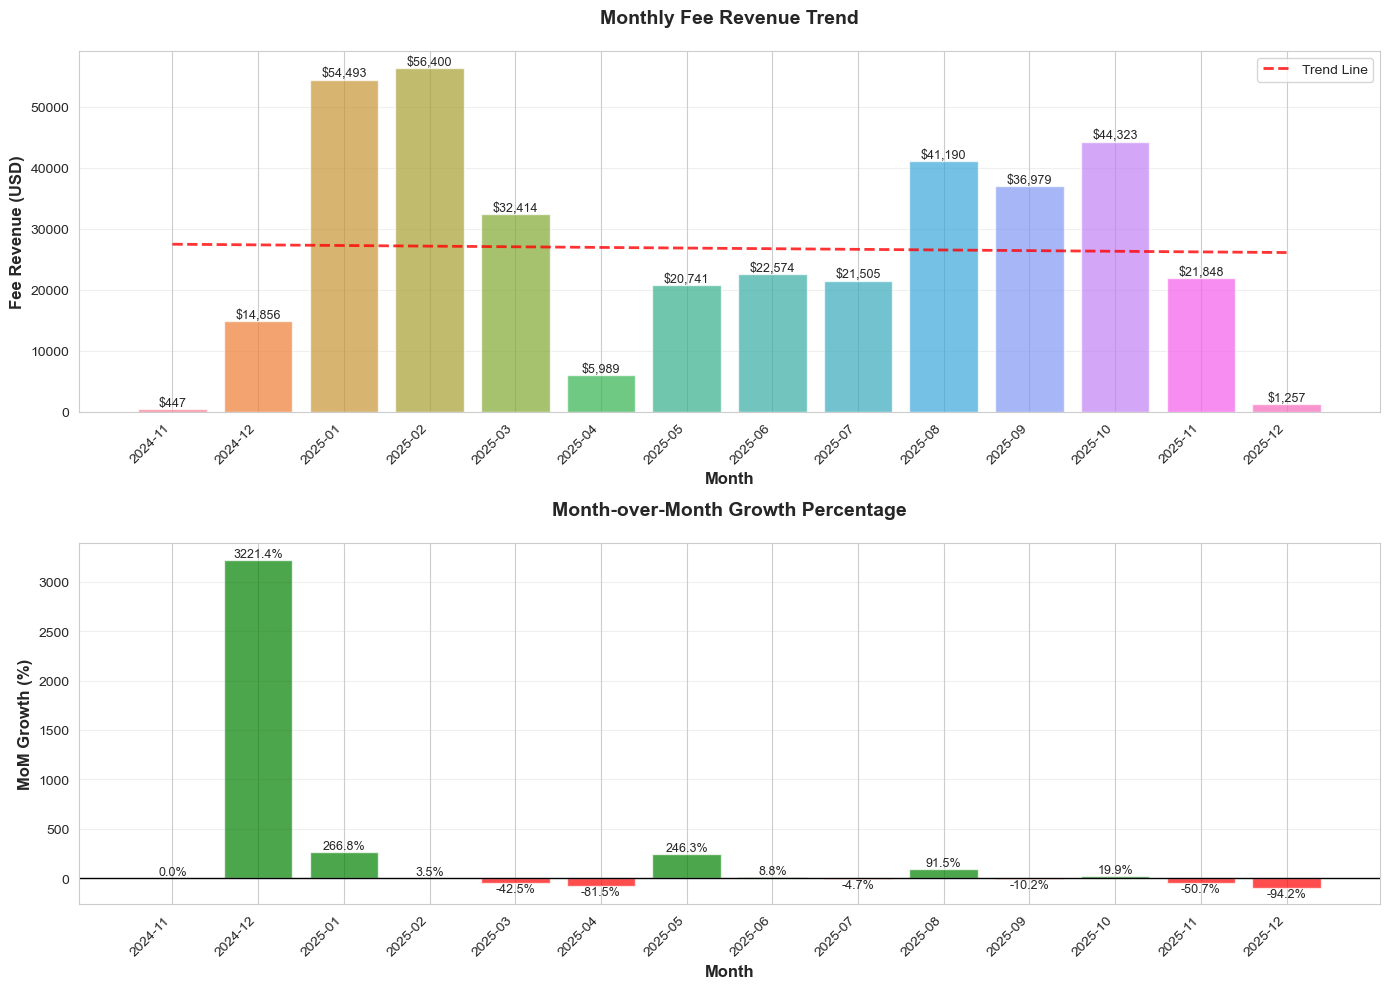

FEE REVENUE TREND ANALYSIS SUMMARY
Top Month: $56,400.11 (2025-02)
Best Growth: 3221.4% (2024-12)

Total Revenue: $375,014.81
Average Monthly Revenue: $26,786.77
Average MoM Growth: 255.3%


In [95]:
# CELL 1: Fee Revenue Trend Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Set professional styling
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Prepare data: Use fee_usd if available, otherwise estimate from affiliate_address
# For this analysis, we'll use a proxy: if affiliate_address exists, assume fee
if 'fee_usd' not in analysis_df.columns:
    # Estimate fee: assume 0.3% of from_amount for swaps with affiliate
    analysis_df['fee_usd'] = np.where(
        analysis_df.get('affiliate_address', pd.Series([None]*len(analysis_df))).notna(),
        analysis_df['from_amount'] * 0.003,  # 0.3% fee estimate
        0
    )

# Ensure timestamp is datetime
if 'timestamp' in analysis_df.columns:
    analysis_df['timestamp'] = pd.to_datetime(analysis_df['timestamp'], errors='coerce')
    
    # Aggregate by month
    analysis_df['year_month'] = analysis_df['timestamp'].dt.to_period('M').astype(str)
    
    monthly_revenue = analysis_df.groupby('year_month').agg({
        'fee_usd': ['sum', 'count', 'mean']
    }).round(2)
    monthly_revenue.columns = ['total_fees', 'swap_count', 'avg_fee_per_swap']
    monthly_revenue = monthly_revenue.reset_index()
    
    # Calculate month-over-month growth
    monthly_revenue['mom_growth_pct'] = monthly_revenue['total_fees'].pct_change() * 100
    monthly_revenue['mom_growth_pct'] = monthly_revenue['mom_growth_pct'].fillna(0)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Top subplot: Monthly fee revenue bar chart with trend line
    bars = ax1.bar(range(len(monthly_revenue)), monthly_revenue['total_fees'], 
                   color=sns.color_palette("husl", len(monthly_revenue)), alpha=0.7)
    ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fee Revenue (USD)', fontsize=12, fontweight='bold')
    ax1.set_title('Monthly Fee Revenue Trend', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(range(len(monthly_revenue)))
    ax1.set_xticklabels(monthly_revenue['year_month'], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add trend line
    z = np.polyfit(range(len(monthly_revenue)), monthly_revenue['total_fees'], 1)
    p = np.poly1d(z)
    ax1.plot(range(len(monthly_revenue)), p(range(len(monthly_revenue))), 
             "r--", alpha=0.8, linewidth=2, label='Trend Line')
    ax1.legend()
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(monthly_revenue.iterrows()):
        ax1.text(i, row['total_fees'], f'${row["total_fees"]:,.0f}', 
                ha='center', va='bottom', fontsize=9)
    
    # Bottom subplot: Month-over-month growth percentage
    colors = ['green' if x >= 0 else 'red' for x in monthly_revenue['mom_growth_pct']]
    ax2.bar(range(len(monthly_revenue)), monthly_revenue['mom_growth_pct'], 
            color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax2.set_ylabel('MoM Growth (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Month-over-Month Growth Percentage', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(range(len(monthly_revenue)))
    ax2.set_xticklabels(monthly_revenue['year_month'], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(monthly_revenue.iterrows()):
        if not pd.isna(row['mom_growth_pct']):
            ax2.text(i, row['mom_growth_pct'], f'{row["mom_growth_pct"]:.1f}%', 
                    ha='center', va='bottom' if row['mom_growth_pct'] >= 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    top_month_idx = monthly_revenue['total_fees'].idxmax()
    top_month = monthly_revenue.loc[top_month_idx]
    best_growth_idx = monthly_revenue['mom_growth_pct'].idxmax()
    best_growth = monthly_revenue.loc[best_growth_idx]
    
    print("=" * 60)
    print("FEE REVENUE TREND ANALYSIS SUMMARY")
    print("=" * 60)
    print(f"Top Month: ${top_month['total_fees']:,.2f} ({top_month['year_month']})")
    print(f"Best Growth: {best_growth['mom_growth_pct']:.1f}% ({best_growth['year_month']})")
    print(f"\nTotal Revenue: ${monthly_revenue['total_fees'].sum():,.2f}")
    print(f"Average Monthly Revenue: ${monthly_revenue['total_fees'].mean():,.2f}")
    print(f"Average MoM Growth: {monthly_revenue['mom_growth_pct'].mean():.1f}%")
    print("=" * 60)
else:
    print("Error: Timestamp column not found or cannot be processed")


### CELL 2: Revenue Concentration Risk (Pareto Analysis)

**Business Question:** Is fee revenue concentrated in a few asset pairs, or is it diversified across many pairs?

**Goal:** Identify if revenue is concentrated (high risk) or diversified (lower risk) for committee risk assessment.


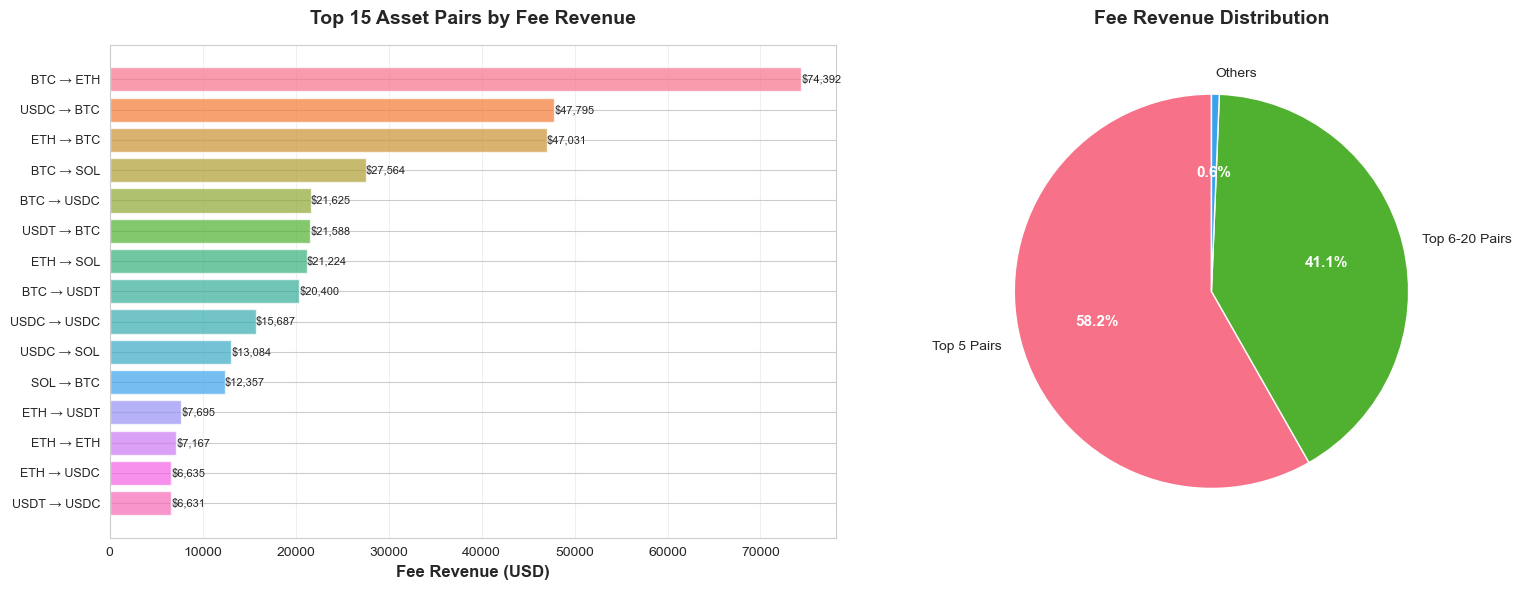

REVENUE CONCENTRATION RISK ANALYSIS
Top 5 pairs = 58.2% of fees
Top 10 pairs = 82.8% of fees
Top 20 pairs = 99.4% of fees

Total unique pairs: 29
Total fee revenue: $375,014.83

⚠️  RISK: Concentration is MEDIUM (40-60%). Moderate diversification.


In [96]:
# CELL 2: Revenue Concentration Risk (Pareto Analysis)

# Group by asset pair and calculate total fees
pair_revenue = analysis_df.groupby(['from_asset', 'to_asset']).agg({
    'fee_usd': 'sum'
}).reset_index()
pair_revenue.columns = ['from_asset', 'to_asset', 'total_fees']
pair_revenue['asset_pair'] = pair_revenue['from_asset'] + ' → ' + pair_revenue['to_asset']

# Rank pairs by fee revenue
pair_revenue = pair_revenue.sort_values('total_fees', ascending=False).reset_index(drop=True)
pair_revenue['rank'] = pair_revenue.index + 1
pair_revenue['cumulative_fees'] = pair_revenue['total_fees'].cumsum()
pair_revenue['cumulative_pct'] = (pair_revenue['cumulative_fees'] / pair_revenue['total_fees'].sum()) * 100

# Calculate concentration metrics
total_fees = pair_revenue['total_fees'].sum()
top_5_pct = (pair_revenue.head(5)['total_fees'].sum() / total_fees) * 100 if len(pair_revenue) >= 5 else 0
top_10_pct = (pair_revenue.head(10)['total_fees'].sum() / total_fees) * 100 if len(pair_revenue) >= 10 else 0
top_20_pct = (pair_revenue.head(20)['total_fees'].sum() / total_fees) * 100 if len(pair_revenue) >= 20 else 0

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Bar chart of top 15 pairs
top_15 = pair_revenue.head(15)
bars = ax1.barh(range(len(top_15)), top_15['total_fees'], 
                color=sns.color_palette("husl", len(top_15)), alpha=0.7)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['asset_pair'], fontsize=9)
ax1.set_xlabel('Fee Revenue (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Asset Pairs by Fee Revenue', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_15.iterrows()):
    ax1.text(row['total_fees'], i, f'${row["total_fees"]:,.0f}', 
            va='center', ha='left', fontsize=8)

# Right: Pie chart showing concentration
top_5_fees = pair_revenue.head(5)['total_fees'].sum()
top_6_20_fees = pair_revenue.iloc[5:20]['total_fees'].sum() if len(pair_revenue) >= 20 else pair_revenue.iloc[5:]['total_fees'].sum()
others_fees = total_fees - top_5_fees - top_6_20_fees

pie_data = [top_5_fees, top_6_20_fees, others_fees]
pie_labels = ['Top 5 Pairs', 'Top 6-20 Pairs', 'Others']
colors_pie = sns.color_palette("husl", 3)

wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
                                    colors=colors_pie, startangle=90)
ax2.set_title('Fee Revenue Distribution', fontsize=14, fontweight='bold', pad=15)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("REVENUE CONCENTRATION RISK ANALYSIS")
print("=" * 60)
print(f"Top 5 pairs = {top_5_pct:.1f}% of fees")
print(f"Top 10 pairs = {top_10_pct:.1f}% of fees")
print(f"Top 20 pairs = {top_20_pct:.1f}% of fees")
print(f"\nTotal unique pairs: {len(pair_revenue)}")
print(f"Total fee revenue: ${total_fees:,.2f}")

# Risk assessment
if top_5_pct > 60:
    risk_level = "HIGH"
    risk_msg = "⚠️  RISK: Concentration is HIGH (>60%). Revenue heavily dependent on top 5 pairs."
elif top_5_pct > 40:
    risk_level = "MEDIUM"
    risk_msg = "⚠️  RISK: Concentration is MEDIUM (40-60%). Moderate diversification."
else:
    risk_level = "LOW"
    risk_msg = "✓ RISK: Concentration is LOW (<40%). Good diversification across pairs."

print(f"\n{risk_msg}")
print("=" * 60)


### CELL 3: User Retention & Engagement

**Business Question:** Are users engaging repeatedly, or do they churn after their first trade?

**Goal:** Show if users are engaged (repeat traders) or churning (one-time traders) for committee engagement assessment.


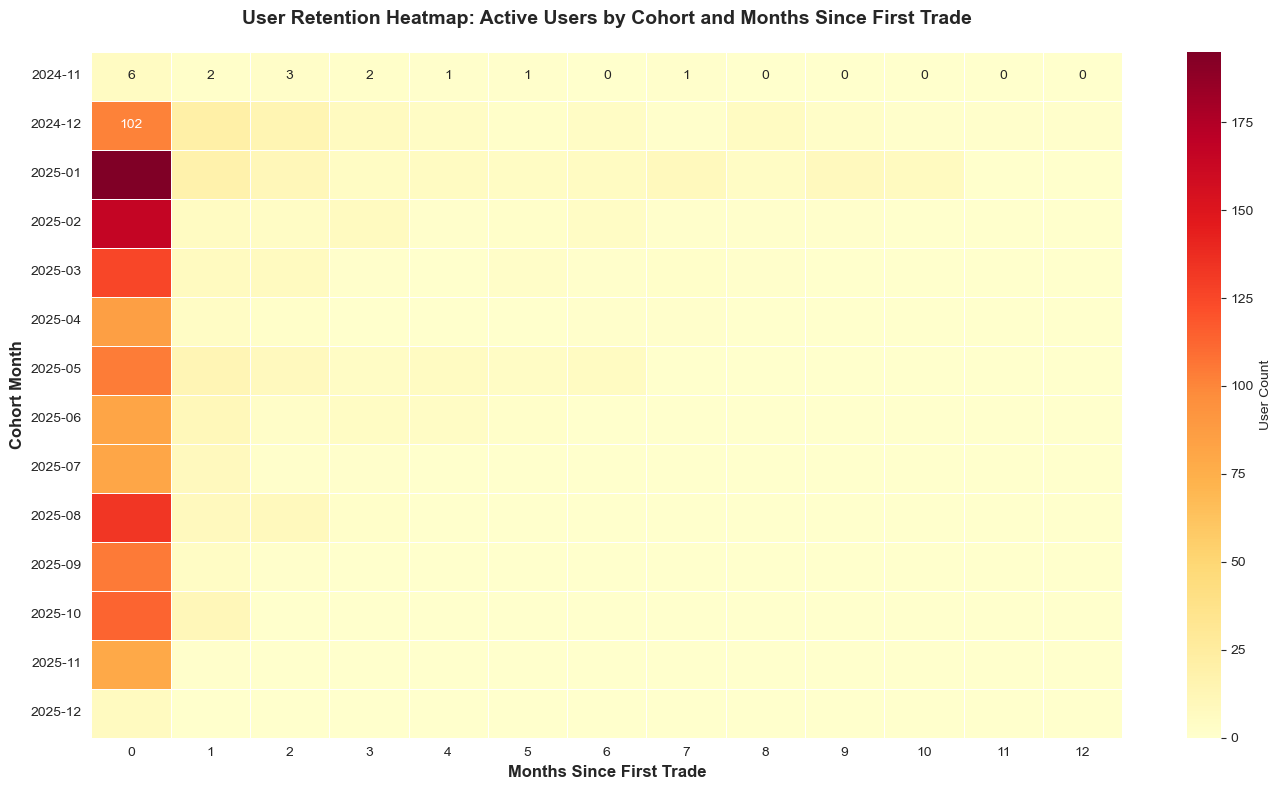

USER RETENTION & ENGAGEMENT ANALYSIS
Total unique users: 1,384
Repeat traders (>1 trade): 421 (30.4%)
Sticky users (10+ trades): 25 (1.8%)

Average trades per user: 1.91
Median trades per user: 1.00


In [97]:
# CELL 3: User Retention & Engagement

# Get user address column (adapt if column name differs)
user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns and 'timestamp' in analysis_df.columns:
    # Calculate first trade date per user
    user_first_trade = analysis_df.groupby(user_col)['timestamp'].min().reset_index()
    user_first_trade.columns = [user_col, 'first_trade_date']
    user_first_trade['cohort_month'] = pd.to_datetime(user_first_trade['first_trade_date']).dt.to_period('M').astype(str)
    
    # Merge back to main dataframe
    analysis_df_with_cohort = analysis_df.merge(user_first_trade, on=user_col, how='left')
    analysis_df_with_cohort['trade_month'] = pd.to_datetime(analysis_df_with_cohort['timestamp']).dt.to_period('M').astype(str)
    
    # Calculate months since first trade
    # Convert to Period objects and calculate difference in months
    def calculate_months_diff(row):
        """Calculate months difference between two period strings"""
        try:
            if pd.isna(row['trade_month']) or pd.isna(row['cohort_month']):
                return 0
            trade_period = pd.Period(row['trade_month'])
            cohort_period = pd.Period(row['cohort_month'])
            return (trade_period - cohort_period).n
        except:
            return 0
    
    analysis_df_with_cohort['months_since_first'] = analysis_df_with_cohort.apply(calculate_months_diff, axis=1)
    
    # Create cohort retention table
    cohort_retention = analysis_df_with_cohort.groupby(['cohort_month', 'months_since_first'])[user_col].nunique().reset_index()
    cohort_retention.columns = ['cohort_month', 'months_since_first', 'user_count']
    
    # Pivot for heatmap
    cohort_pivot = cohort_retention.pivot(index='cohort_month', columns='months_since_first', values='user_count').fillna(0)
    
    # Calculate engagement metrics
    user_trade_counts = analysis_df.groupby(user_col).size().reset_index(name='trade_count')
    repeat_traders = len(user_trade_counts[user_trade_counts['trade_count'] > 1])
    sticky_users = len(user_trade_counts[user_trade_counts['trade_count'] >= 10])
    total_users = len(user_trade_counts)
    
    repeat_pct = (repeat_traders / total_users * 100) if total_users > 0 else 0
    sticky_pct = (sticky_users / total_users * 100) if total_users > 0 else 0
    
    # Create heatmap visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create heatmap
    sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
                cbar_kws={'label': 'User Count'}, ax=ax, linewidths=0.5)
    ax.set_xlabel('Months Since First Trade', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cohort Month', fontsize=12, fontweight='bold')
    ax.set_title('User Retention Heatmap: Active Users by Cohort and Months Since First Trade', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=" * 60)
    print("USER RETENTION & ENGAGEMENT ANALYSIS")
    print("=" * 60)
    print(f"Total unique users: {total_users:,}")
    print(f"Repeat traders (>1 trade): {repeat_traders:,} ({repeat_pct:.1f}%)")
    print(f"Sticky users (10+ trades): {sticky_users:,} ({sticky_pct:.1f}%)")
    print(f"\nAverage trades per user: {user_trade_counts['trade_count'].mean():.2f}")
    print(f"Median trades per user: {user_trade_counts['trade_count'].median():.2f}")
    print("=" * 60)
else:
    print("Error: User address or timestamp column not found")


### CELL 4: Trading Time Patterns (Heatmap)

**Business Question:** When do users trade most actively? What are the peak trading hours and days?

**Goal:** Identify best times for promotions and protocol maintenance windows.


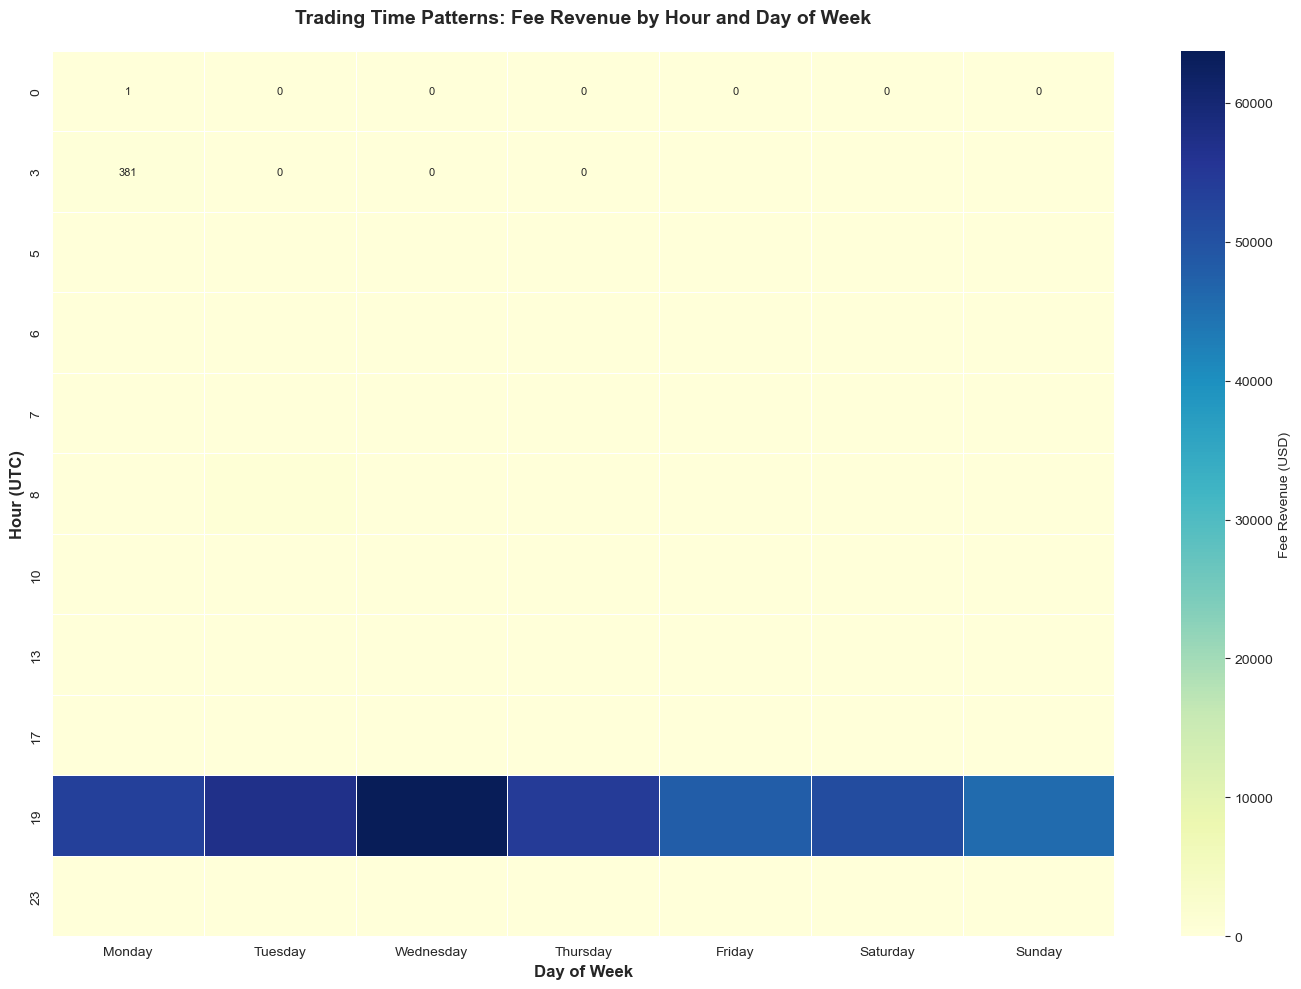

TRADING TIME PATTERNS ANALYSIS
Peak trading time: Wednesday at 19:00 UTC
Peak fee revenue: $63,744.31

Top 5 trading periods:
  Wednesday 19:00 UTC: $63,744.31
  Tuesday 19:00 UTC: $57,159.15
  Thursday 19:00 UTC: $54,404.28
  Monday 19:00 UTC: $53,365.71
  Saturday 19:00 UTC: $51,292.86


In [98]:
# CELL 4: Trading Time Patterns (Heatmap)

if 'timestamp' in analysis_df.columns:
    # Extract hour and day of week
    analysis_df['hour'] = pd.to_datetime(analysis_df['timestamp']).dt.hour
    analysis_df['day_of_week'] = pd.to_datetime(analysis_df['timestamp']).dt.day_name()
    
    # Create pivot table: rows=hour, columns=day, values=SUM(fee_usd)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    time_pivot = analysis_df.pivot_table(
        values='fee_usd',
        index='hour',
        columns='day_of_week',
        aggfunc='sum',
        fill_value=0
    )
    time_pivot = time_pivot.reindex(columns=day_order, fill_value=0)
    
    # Create annotated heatmap
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create heatmap with annotations
    sns.heatmap(time_pivot, annot=True, fmt='.0f', cmap='YlGnBu', 
                cbar_kws={'label': 'Fee Revenue (USD)'}, ax=ax, 
                linewidths=0.5, annot_kws={'size': 8})
    
    ax.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
    ax.set_ylabel('Hour (UTC)', fontsize=12, fontweight='bold')
    ax.set_title('Trading Time Patterns: Fee Revenue by Hour and Day of Week', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Find peak trading time
    max_value = time_pivot.max().max()
    peak_idx = time_pivot.stack().idxmax()
    peak_hour, peak_day = peak_idx
    
    print("=" * 60)
    print("TRADING TIME PATTERNS ANALYSIS")
    print("=" * 60)
    print(f"Peak trading time: {peak_day} at {peak_hour}:00 UTC")
    print(f"Peak fee revenue: ${max_value:,.2f}")
    print(f"\nTop 5 trading periods:")
    top_periods = time_pivot.stack().sort_values(ascending=False).head(5)
    for (hour, day), value in top_periods.items():
        print(f"  {day} {hour}:00 UTC: ${value:,.2f}")
    print("=" * 60)
else:
    print("Error: Timestamp column not found")


### CELL 5: Top 20 Whale Users Deep Dive

**Business Question:** How dependent is fee revenue on a small number of high-volume users (whales)?

**Goal:** Identify whale dependency risk for committee risk assessment.


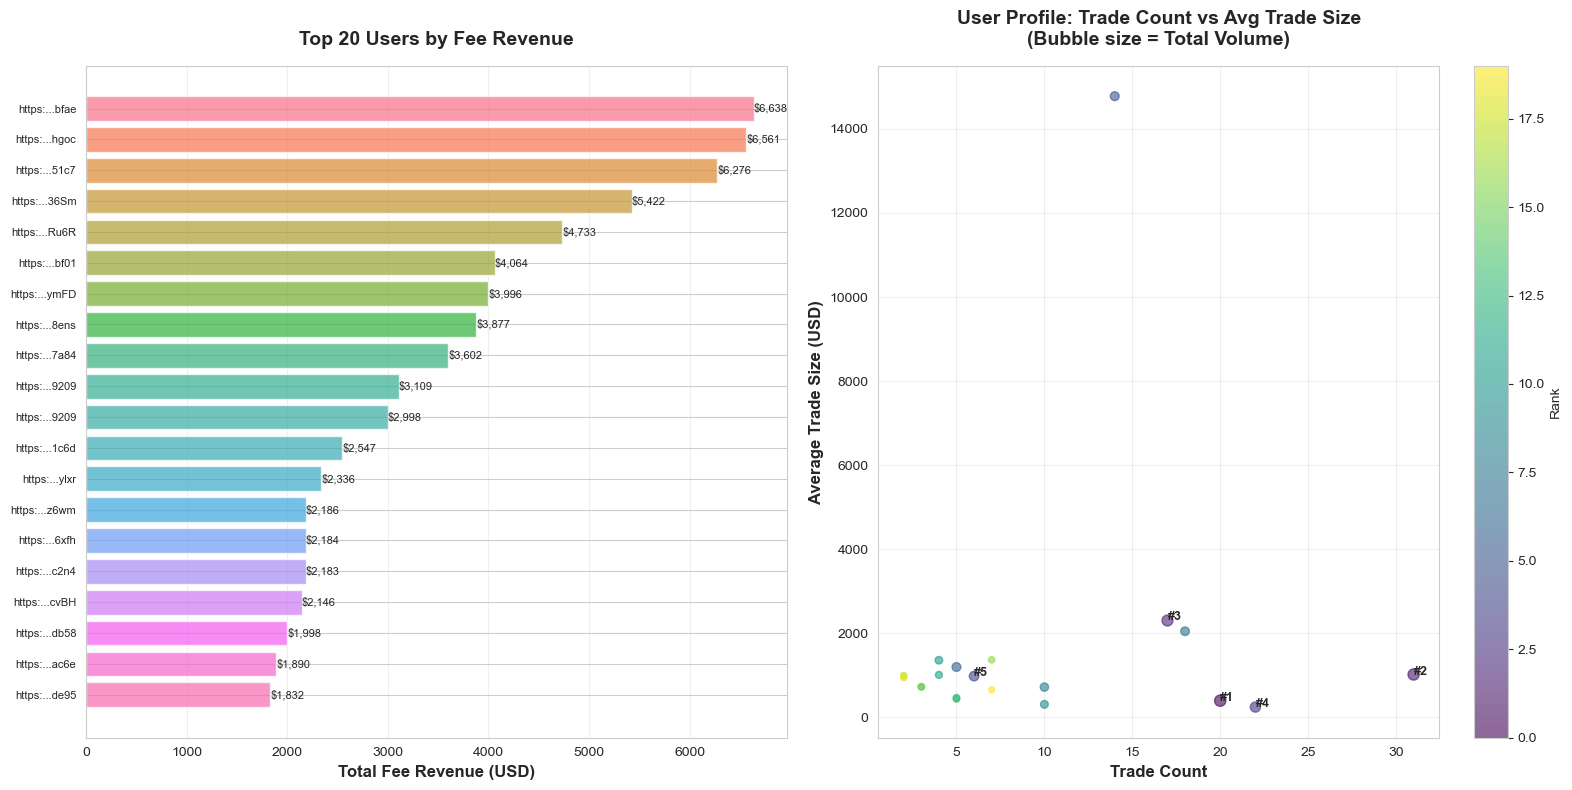

TOP 20 WHALE USERS ANALYSIS
Top 10 users = 12.9% of fees
Top 20 users = 18.8% of fees

Total unique users: 1,384
Total fee revenue: $375,014.83

✓ CONCENTRATION RISK: LOW (<30%). Good user diversification.

Top 5 users:
  #1: $6,637.66 (20 trades, avg $398.07)
  #2: $6,561.43 (31 trades, avg $1,021.14)
  #3: $6,275.77 (17 trades, avg $2,305.78)
  #4: $5,422.08 (22 trades, avg $246.46)
  #5: $4,733.30 (6 trades, avg $983.03)


In [99]:
# CELL 5: Top 20 Whale Users Deep Dive

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns:
    # Group by user and calculate metrics
    user_stats = analysis_df.groupby(user_col).agg({
        'fee_usd': 'sum',
        'from_amount': ['count', 'mean'],
        'timestamp': ['min', 'max']
    }).reset_index()
    user_stats.columns = [user_col, 'total_volume', 'trade_count', 'avg_trade_size', 
                         'first_trade_date', 'last_trade_date']
    
    # Sort by total volume (fee revenue)
    user_stats = user_stats.sort_values('total_volume', ascending=False).reset_index(drop=True)
    
    # Calculate concentration metrics
    total_fees_all = user_stats['total_volume'].sum()
    top_10_pct = (user_stats.head(10)['total_volume'].sum() / total_fees_all * 100) if len(user_stats) >= 10 else 0
    top_20_pct = (user_stats.head(20)['total_volume'].sum() / total_fees_all * 100) if len(user_stats) >= 20 else 0
    
    # Get top 20 for visualization
    top_20 = user_stats.head(20).copy()
    
    # Anonymize addresses for display (show first 6 and last 4 chars)
    top_20['user_id'] = top_20[user_col].apply(
        lambda x: f"{str(x)[:6]}...{str(x)[-4:]}" if len(str(x)) > 10 else str(x)
    )
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left: Bar chart of top 20 users by volume
    bars = ax1.barh(range(len(top_20)), top_20['total_volume'], 
                    color=sns.color_palette("husl", len(top_20)), alpha=0.7)
    ax1.set_yticks(range(len(top_20)))
    ax1.set_yticklabels(top_20['user_id'], fontsize=8)
    ax1.set_xlabel('Total Fee Revenue (USD)', fontsize=12, fontweight='bold')
    ax1.set_title('Top 20 Users by Fee Revenue', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.invert_yaxis()
    
    # Add value labels
    for i, (idx, row) in enumerate(top_20.iterrows()):
        ax1.text(row['total_volume'], i, f'${row["total_volume"]:,.0f}', 
                va='center', ha='left', fontsize=8)
    
    # Right: Scatter plot: X=trade_count, Y=avg_trade_size, size=total_volume
    scatter = ax2.scatter(top_20['trade_count'], top_20['avg_trade_size'], 
                         s=top_20['total_volume']/100, alpha=0.6, 
                         c=range(len(top_20)), cmap='viridis')
    ax2.set_xlabel('Trade Count', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Trade Size (USD)', fontsize=12, fontweight='bold')
    ax2.set_title('User Profile: Trade Count vs Avg Trade Size\n(Bubble size = Total Volume)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3)
    
    # Add labels to top 5 users
    for i, (idx, row) in enumerate(top_20.head(5).iterrows()):
        ax2.annotate(f"#{i+1}", (row['trade_count'], row['avg_trade_size']), 
                    fontsize=9, fontweight='bold')
    
    plt.colorbar(scatter, ax=ax2, label='Rank')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=" * 60)
    print("TOP 20 WHALE USERS ANALYSIS")
    print("=" * 60)
    print(f"Top 10 users = {top_10_pct:.1f}% of fees")
    print(f"Top 20 users = {top_20_pct:.1f}% of fees")
    print(f"\nTotal unique users: {len(user_stats):,}")
    print(f"Total fee revenue: ${total_fees_all:,.2f}")
    
    # Risk assessment
    if top_10_pct > 50:
        risk_level = "HIGH"
        risk_msg = "⚠️  CONCENTRATION RISK: HIGH (>50%). Revenue heavily dependent on top 10 users."
    elif top_10_pct > 30:
        risk_level = "MEDIUM"
        risk_msg = "⚠️  CONCENTRATION RISK: MEDIUM (30-50%). Moderate whale dependency."
    else:
        risk_level = "LOW"
        risk_msg = "✓ CONCENTRATION RISK: LOW (<30%). Good user diversification."
    
    print(f"\n{risk_msg}")
    print(f"\nTop 5 users:")
    for i, (idx, row) in enumerate(top_20.head(5).iterrows()):
        print(f"  #{i+1}: ${row['total_volume']:,.2f} ({row['trade_count']} trades, avg ${row['avg_trade_size']:,.2f})")
    print("=" * 60)
else:
    print("Error: User address column not found")


### CELL 6: Asset Pair Performance Matrix

**Business Question:** Which asset pairs are most reliable for fee generation? Which are most volatile?

**Goal:** Show which pairs are reliable (stable) vs volatile (risky) for fee generation.


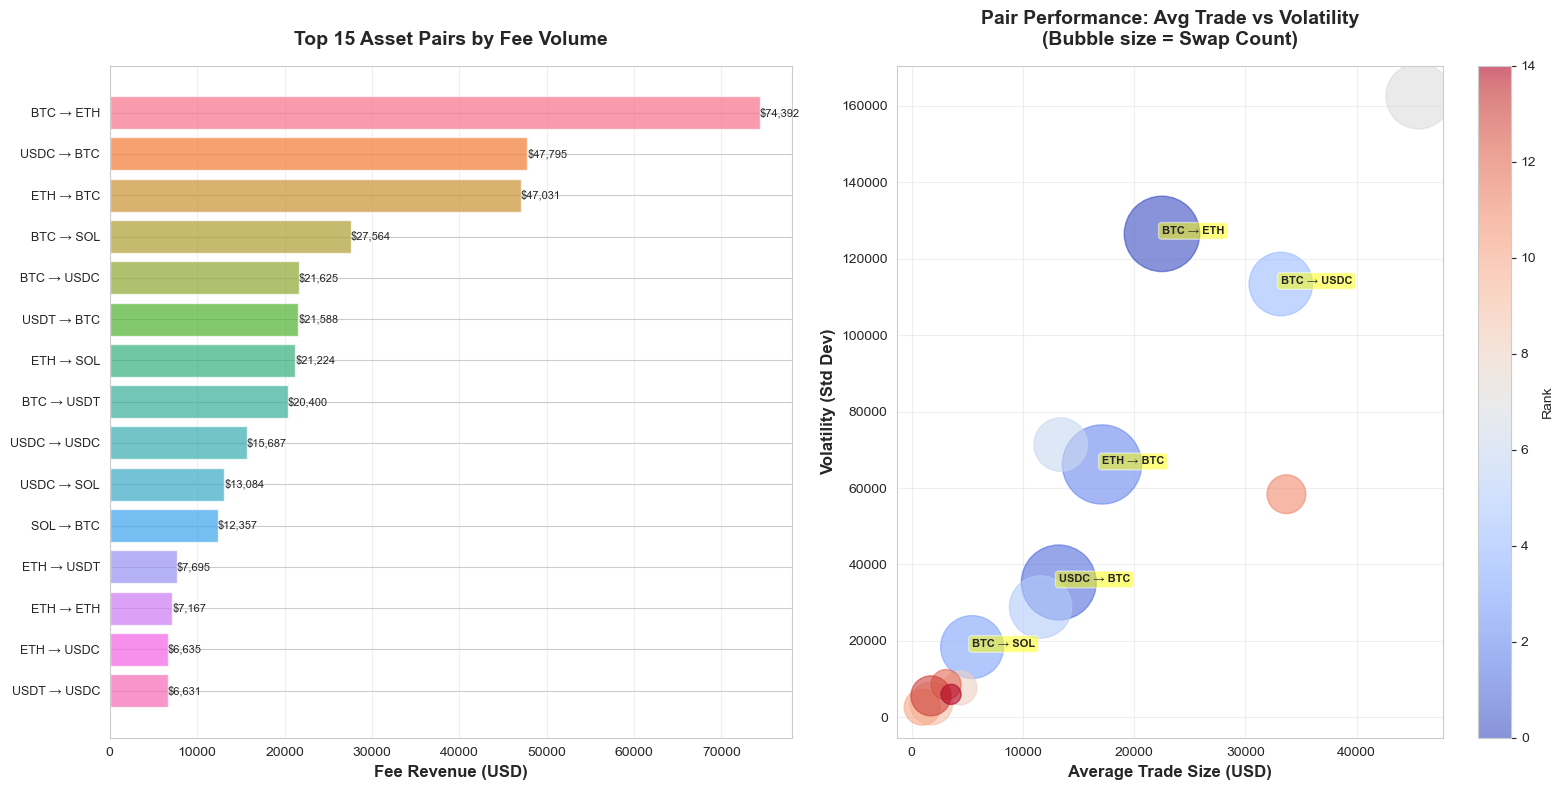

ASSET PAIR PERFORMANCE MATRIX
Most stable pair: FLIP → USDC (CV: 0.691, Volatility: $4,434.25)
Most volatile pair: BTC → ETH (CV: 5.621, Volatility: $126,484.73)

Top 15 pairs by volume:
  #1: BTC → ETH - $74,391.75 (295 swaps, avg $22,503.93)
  #2: USDC → BTC - $47,794.62 (291 swaps, avg $13,228.15)
  #3: ETH → BTC - $47,031.21 (325 swaps, avg $17,113.01)
  #4: BTC → SOL - $27,563.55 (205 swaps, avg $5,431.64)
  #5: BTC → USDC - $21,625.44 (209 swaps, avg $33,192.89)
  #6: USDT → BTC - $21,588.24 (201 swaps, avg $11,587.14)
  #7: ETH → SOL - $21,223.55 (148 swaps, avg $13,389.67)
  #8: BTC → USDT - $20,399.64 (223 swaps, avg $45,587.73)
  #9: USDC → USDC - $15,686.54 (60 swaps, avg $4,331.92)
  #10: USDC → SOL - $13,083.60 (95 swaps, avg $1,758.13)
  #11: SOL → BTC - $12,356.88 (67 swaps, avg $945.67)
  #12: ETH → USDT - $7,694.86 (78 swaps, avg $33,695.68)
  #13: ETH → ETH - $7,166.96 (47 swaps, avg $3,090.95)
  #14: ETH → USDC - $6,635.37 (83 swaps, avg $1,729.11)
  #15: USDT → USDC

In [100]:
# CELL 6: Asset Pair Performance Matrix

# Group by asset pair and calculate metrics
pair_performance = analysis_df.groupby(['from_asset', 'to_asset']).agg({
    'fee_usd': 'sum',
    'from_amount': ['count', 'mean', 'std']
}).reset_index()
pair_performance.columns = ['from_asset', 'to_asset', 'pair_volume', 'swap_count', 
                           'avg_trade', 'volatility']
pair_performance['asset_pair'] = pair_performance['from_asset'] + ' → ' + pair_performance['to_asset']

# Fill NaN volatility with 0 (for pairs with only 1 swap)
pair_performance['volatility'] = pair_performance['volatility'].fillna(0)

# Sort by volume and get top 15
pair_performance = pair_performance.sort_values('pair_volume', ascending=False).reset_index(drop=True)
top_15_pairs = pair_performance.head(15).copy()

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left: Horizontal bar chart of top 15 pairs by volume
bars = ax1.barh(range(len(top_15_pairs)), top_15_pairs['pair_volume'], 
                color=sns.color_palette("husl", len(top_15_pairs)), alpha=0.7)
ax1.set_yticks(range(len(top_15_pairs)))
ax1.set_yticklabels(top_15_pairs['asset_pair'], fontsize=9)
ax1.set_xlabel('Fee Revenue (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Asset Pairs by Fee Volume', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_15_pairs.iterrows()):
    ax1.text(row['pair_volume'], i, f'${row["pair_volume"]:,.0f}', 
            va='center', ha='left', fontsize=8)

# Right: Scatter plot: X=avg_trade, Y=volatility, bubble_size=swap_count
# Filter to pairs with at least 2 swaps for meaningful volatility
scatter_data = top_15_pairs[top_15_pairs['swap_count'] >= 2].copy()

if len(scatter_data) > 0:
    scatter = ax2.scatter(scatter_data['avg_trade'], scatter_data['volatility'], 
                         s=scatter_data['swap_count']*10, alpha=0.6, 
                         c=range(len(scatter_data)), cmap='coolwarm')
    ax2.set_xlabel('Average Trade Size (USD)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Volatility (Std Dev)', fontsize=12, fontweight='bold')
    ax2.set_title('Pair Performance: Avg Trade vs Volatility\n(Bubble size = Swap Count)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3)
    
    # Add labels to top 5 pairs
    for i, (idx, row) in enumerate(scatter_data.head(5).iterrows()):
        ax2.annotate(row['asset_pair'], (row['avg_trade'], row['volatility']), 
                    fontsize=8, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
    
    plt.colorbar(scatter, ax=ax2, label='Rank')
else:
    ax2.text(0.5, 0.5, 'Insufficient data\nfor volatility analysis', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Pair Performance: Avg Trade vs Volatility', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("ASSET PAIR PERFORMANCE MATRIX")
print("=" * 60)

# Find most stable and most volatile pairs (with at least 5 swaps)
stable_pairs = pair_performance[pair_performance['swap_count'] >= 5].copy()
if len(stable_pairs) > 0:
    stable_pairs['cv'] = stable_pairs['volatility'] / stable_pairs['avg_trade']  # coefficient of variation
    stable_pairs = stable_pairs[stable_pairs['cv'] > 0]  # Remove pairs with zero volatility
    
    if len(stable_pairs) > 0:
        most_stable = stable_pairs.loc[stable_pairs['cv'].idxmin()]
        most_volatile = stable_pairs.loc[stable_pairs['cv'].idxmax()]
        
        print(f"Most stable pair: {most_stable['asset_pair']} (CV: {most_stable['cv']:.3f}, Volatility: ${most_stable['volatility']:,.2f})")
        print(f"Most volatile pair: {most_volatile['asset_pair']} (CV: {most_volatile['cv']:.3f}, Volatility: ${most_volatile['volatility']:,.2f})")
    else:
        print("Insufficient data for stability analysis")
else:
    print("Insufficient data for stability analysis (need pairs with 5+ swaps)")

print(f"\nTop 15 pairs by volume:")
for i, (idx, row) in enumerate(top_15_pairs.iterrows()):
    print(f"  #{i+1}: {row['asset_pair']} - ${row['pair_volume']:,.2f} ({row['swap_count']} swaps, avg ${row['avg_trade']:,.2f})")
print("=" * 60)


### CELL 7: Week-over-Week Growth Dashboard

**Business Question:** What is the current momentum? Is growth accelerating or decelerating?

**Goal:** Show momentum and accelerating/decelerating growth trends for committee decision-making.


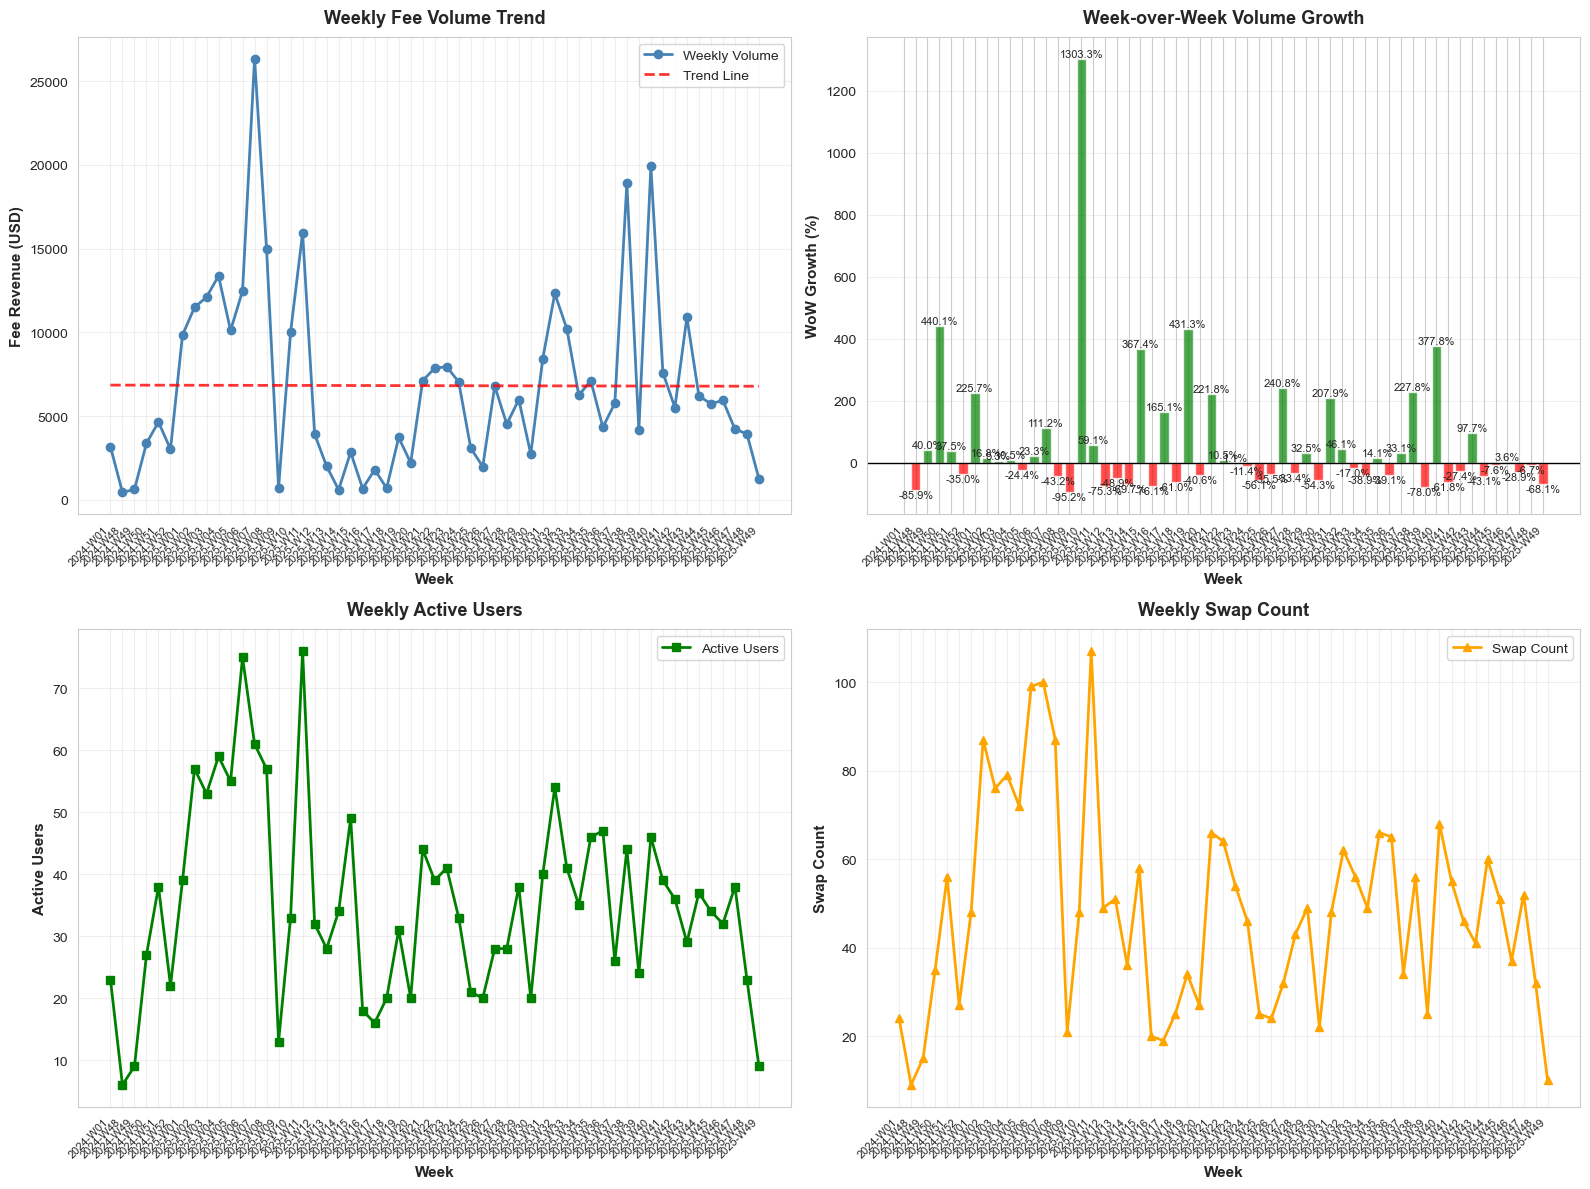

WEEK-OVER-WEEK GROWTH DASHBOARD
Current trend: STRONG DECLINE
YoY growth (first 4 vs last 4 weeks): 101.4%
Average recent WoW growth (last 4 weeks): -25.0%
Latest week WoW growth: -68.1%

Total weeks analyzed: 55
Total volume: $375,014.83
Total swaps: 2,647
Total unique users: 1,943


In [101]:
# CELL 7: Week-over-Week Growth Dashboard

if 'timestamp' in analysis_df.columns:
    # Extract week information
    analysis_df['year'] = pd.to_datetime(analysis_df['timestamp']).dt.year
    analysis_df['week'] = pd.to_datetime(analysis_df['timestamp']).dt.isocalendar().week
    analysis_df['year_week'] = analysis_df['year'].astype(str) + '-W' + analysis_df['week'].astype(str).str.zfill(2)
    
    user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'
    
    # Aggregate by week
    weekly_stats = analysis_df.groupby('year_week').agg({
        'fee_usd': 'sum',
        'from_amount': 'count'
    }).reset_index()
    weekly_stats.columns = ['year_week', 'weekly_volume', 'weekly_swaps']
    
    # Count distinct users per week
    if user_col in analysis_df.columns:
        weekly_users = analysis_df.groupby('year_week')[user_col].nunique().reset_index()
        weekly_users.columns = ['year_week', 'weekly_users']
        weekly_stats = weekly_stats.merge(weekly_users, on='year_week', how='left')
    else:
        weekly_stats['weekly_users'] = 0
    
    # Calculate week-over-week growth
    weekly_stats['wow_volume_growth'] = weekly_stats['weekly_volume'].pct_change() * 100
    weekly_stats['wow_swaps_growth'] = weekly_stats['weekly_swaps'].pct_change() * 100
    weekly_stats['wow_users_growth'] = weekly_stats['weekly_users'].pct_change() * 100
    
    # Fill NaN with 0 for first week
    weekly_stats = weekly_stats.fillna(0)
    
    # Sort by year_week for proper ordering
    weekly_stats = weekly_stats.sort_values('year_week').reset_index(drop=True)
    
    # Create 2x2 subplot dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top-left: Line chart of weekly volume with trend line
    ax1.plot(range(len(weekly_stats)), weekly_stats['weekly_volume'], 
            marker='o', linewidth=2, markersize=6, color='steelblue', label='Weekly Volume')
    ax1.set_xlabel('Week', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Fee Revenue (USD)', fontsize=11, fontweight='bold')
    ax1.set_title('Weekly Fee Volume Trend', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xticks(range(len(weekly_stats)))
    ax1.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(range(len(weekly_stats)), weekly_stats['weekly_volume'], 1)
    p = np.poly1d(z)
    ax1.plot(range(len(weekly_stats)), p(range(len(weekly_stats))), 
            "r--", alpha=0.8, linewidth=2, label='Trend Line')
    ax1.legend()
    
    # Top-right: Column chart of WoW growth % (green if +, red if -)
    colors_wow = ['green' if x >= 0 else 'red' for x in weekly_stats['wow_volume_growth']]
    ax2.bar(range(len(weekly_stats)), weekly_stats['wow_volume_growth'], 
           color=colors_wow, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Week', fontsize=11, fontweight='bold')
    ax2.set_ylabel('WoW Growth (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Week-over-Week Volume Growth', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xticks(range(len(weekly_stats)))
    ax2.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(weekly_stats.iterrows()):
        if not pd.isna(row['wow_volume_growth']) and row['wow_volume_growth'] != 0:
            ax2.text(i, row['wow_volume_growth'], f'{row["wow_volume_growth"]:.1f}%', 
                    ha='center', va='bottom' if row['wow_volume_growth'] >= 0 else 'top', fontsize=8)
    
    # Bottom-left: Line chart of active users per week
    if weekly_stats['weekly_users'].sum() > 0:
        ax3.plot(range(len(weekly_stats)), weekly_stats['weekly_users'], 
                marker='s', linewidth=2, markersize=6, color='green', label='Active Users')
        ax3.set_xlabel('Week', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Active Users', fontsize=11, fontweight='bold')
        ax3.set_title('Weekly Active Users', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xticks(range(len(weekly_stats)))
        ax3.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'User data not available', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Weekly Active Users', fontsize=13, fontweight='bold')
    
    # Bottom-right: Line chart of weekly swap count
    ax4.plot(range(len(weekly_stats)), weekly_stats['weekly_swaps'], 
            marker='^', linewidth=2, markersize=6, color='orange', label='Swap Count')
    ax4.set_xlabel('Week', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Swap Count', fontsize=11, fontweight='bold')
    ax4.set_title('Weekly Swap Count', fontsize=13, fontweight='bold', pad=10)
    ax4.set_xticks(range(len(weekly_stats)))
    ax4.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate trend and YoY growth
    latest_week_growth = weekly_stats['wow_volume_growth'].iloc[-1] if len(weekly_stats) > 1 else 0
    avg_recent_growth = weekly_stats['wow_volume_growth'].tail(4).mean() if len(weekly_stats) >= 4 else latest_week_growth
    
    # Determine trend
    if avg_recent_growth > 5:
        trend = "STRONG GROWTH"
    elif avg_recent_growth > 0:
        trend = "GROWTH"
    elif avg_recent_growth > -5:
        trend = "DECLINE"
    else:
        trend = "STRONG DECLINE"
    
    # Calculate YoY growth (compare first 4 weeks vs last 4 weeks if available)
    if len(weekly_stats) >= 8:
        first_4_avg = weekly_stats.head(4)['weekly_volume'].mean()
        last_4_avg = weekly_stats.tail(4)['weekly_volume'].mean()
        yoy_growth = ((last_4_avg - first_4_avg) / first_4_avg * 100) if first_4_avg > 0 else 0
    else:
        yoy_growth = None
    
    # Print summary statistics
    print("=" * 60)
    print("WEEK-OVER-WEEK GROWTH DASHBOARD")
    print("=" * 60)
    print(f"Current trend: {trend}")
    if yoy_growth is not None:
        print(f"YoY growth (first 4 vs last 4 weeks): {yoy_growth:.1f}%")
    print(f"Average recent WoW growth (last 4 weeks): {avg_recent_growth:.1f}%")
    print(f"Latest week WoW growth: {latest_week_growth:.1f}%")
    print(f"\nTotal weeks analyzed: {len(weekly_stats)}")
    print(f"Total volume: ${weekly_stats['weekly_volume'].sum():,.2f}")
    print(f"Total swaps: {weekly_stats['weekly_swaps'].sum():,}")
    if weekly_stats['weekly_users'].sum() > 0:
        print(f"Total unique users: {weekly_stats['weekly_users'].sum():,}")
    print("=" * 60)
else:
    print("Error: Timestamp column not found")


In [102]:
# IMPROVEMENT 1: Separate Add vs Swap transactions
print("=== IMPROVEMENT 1: Transaction Type Breakdown ===\n")

# Filter swaps only (exclude Add transactions for swap-specific analysis)
swaps_only = analysis_df[analysis_df['type'] == 'Swap'].copy()
adds_only = analysis_df[analysis_df['type'] == 'Add'].copy()

print(f"Total transactions: {len(analysis_df):,}")
print(f"  Swaps: {len(swaps_only):,} ({len(swaps_only)/len(analysis_df)*100:.1f}%)")
print(f"  Adds: {len(adds_only):,} ({len(adds_only)/len(analysis_df)*100:.1f}%)")

if len(swaps_only) > 0:
    print(f"\nSwap-specific statistics:")
    print(f"  Average swap size: {swaps_only['from_amount'].mean():.2f}")
    print(f"  Median swap size: {swaps_only['from_amount'].median():.2f}")
    print(f"  Total swap volume: {swaps_only['from_amount'].sum():,.2f}")

if len(adds_only) > 0:
    print(f"\nAdd-specific statistics:")
    print(f"  Average add amount: {adds_only['from_amount'].mean():.2f}")
    print(f"  Median add amount: {adds_only['from_amount'].median():.2f}")
    print(f"  Total liquidity added: {adds_only['from_amount'].sum():,.2f}")

# Use swaps_only for subsequent swap analysis
analysis_df_swaps = swaps_only.copy()



=== IMPROVEMENT 1: Transaction Type Breakdown ===

Total transactions: 2,647
  Swaps: 2,647 (100.0%)
  Adds: 0 (0.0%)

Swap-specific statistics:
  Average swap size: 20210.02
  Median swap size: 1280.12
  Total swap volume: 53,495,918.35


In [103]:
# IMPROVEMENT 2: Calculate actual fee percentage/basis points
print("=== IMPROVEMENT 2: Fee Analysis (Basis Points) ===\n")

if len(analysis_df_swaps) > 0:
    # Calculate fee as percentage difference
    # Note: This assumes fee is reflected in the ratio difference
    # For swaps: fee_bps = ((from_amount / to_amount) - 1) * 10000
    # But we need to account for different assets, so we'll use a simplified approach
    
    # Calculate effective fee rate (simplified - assumes 1:1 asset ratio for same-asset swaps)
    same_asset_swaps = analysis_df_swaps[analysis_df_swaps['from_asset'] == analysis_df_swaps['to_asset']].copy()
    
    if len(same_asset_swaps) > 0:
        same_asset_swaps['fee_percentage'] = ((same_asset_swaps['from_amount'] - same_asset_swaps['to_amount']) / same_asset_swaps['from_amount']) * 100
        same_asset_swaps['fee_bps'] = same_asset_swaps['fee_percentage'] * 100
        
        print(f"Same-asset swaps (for fee calculation): {len(same_asset_swaps):,}")
        print(f"  Average fee: {same_asset_swaps['fee_percentage'].mean():.4f}%")
        print(f"  Average fee: {same_asset_swaps['fee_bps'].mean():.2f} basis points")
        print(f"  Median fee: {same_asset_swaps['fee_bps'].median():.2f} basis points")
        
        # Add fee columns to main dataframe
        analysis_df_swaps['fee_percentage'] = None
        analysis_df_swaps['fee_bps'] = None
        analysis_df_swaps.loc[same_asset_swaps.index, 'fee_percentage'] = same_asset_swaps['fee_percentage']
        analysis_df_swaps.loc[same_asset_swaps.index, 'fee_bps'] = same_asset_swaps['fee_bps']
    else:
        print("No same-asset swaps found for fee calculation")
        analysis_df_swaps['fee_percentage'] = None
        analysis_df_swaps['fee_bps'] = None
    
    # Fee by affiliate presence
    if 'has_fee' in analysis_df_swaps.columns:
        fee_by_affiliate = analysis_df_swaps.groupby('has_fee').agg({
            'from_amount': ['count', 'mean', 'sum'],
            'fee_bps': 'mean'
        })
        print(f"\nFee analysis by affiliate presence:")
        print(fee_by_affiliate)



=== IMPROVEMENT 2: Fee Analysis (Basis Points) ===

Same-asset swaps (for fee calculation): 123
  Average fee: 1.9063%
  Average fee: 190.63 basis points
  Median fee: 71.39 basis points


In [104]:
# IMPROVEMENT 3: Volume-weighted metrics
print("=== IMPROVEMENT 3: Volume-Weighted Metrics ===\n")

if len(analysis_df_swaps) > 0:
    # Volume-weighted average swap size by asset
    volume_weighted = analysis_df_swaps.groupby('from_asset').agg({
        'from_amount': ['sum', 'count', 'mean'],
        'to_amount': 'sum'
    }).round(2)
    volume_weighted.columns = ['total_volume', 'swap_count', 'avg_size', 'total_received']
    volume_weighted['volume_weighted_avg'] = volume_weighted['total_volume'] / volume_weighted['swap_count']
    volume_weighted = volume_weighted.sort_values('total_volume', ascending=False)
    
    print("Top 10 assets by volume (volume-weighted):")
    print(volume_weighted.head(10))
    
    # Overall volume-weighted average
    total_volume = analysis_df_swaps['from_amount'].sum()
    total_count = len(analysis_df_swaps)
    volume_weighted_overall = total_volume / total_count
    
    print(f"\nOverall volume-weighted average: {volume_weighted_overall:,.2f}")
    print(f"Simple average: {analysis_df_swaps['from_amount'].mean():,.2f}")
    print(f"Difference: {volume_weighted_overall - analysis_df_swaps['from_amount'].mean():,.2f}")



=== IMPROVEMENT 3: Volume-Weighted Metrics ===

Top 10 assets by volume (volume-weighted):
            total_volume  swap_count  avg_size  total_received  \
from_asset                                                       
BTC          30768799.93         946  32525.16     30472635.42   
ETH          10483942.20         684  15327.40     10324727.79   
USDT          6729637.09         290  23205.65      6678055.74   
USDC          5080790.75         545   9322.55      5025372.40   
SOL            277794.70         158   1758.19       275101.23   
FLIP           154953.69          24   6456.40       150207.95   

            volume_weighted_avg  
from_asset                       
BTC                32525.158488  
ETH                15327.400877  
USDT               23205.645138  
USDC                9322.551835  
SOL                 1758.194304  
FLIP                6456.403750  

Overall volume-weighted average: 20,210.02
Simple average: 20,210.02
Difference: 0.00


In [105]:
# IMPROVEMENT 4: Hour-of-day analysis
print("=== IMPROVEMENT 4: Hour-of-Day Analysis ===\n")

if len(analysis_df_swaps) > 0 and 'timestamp' in analysis_df_swaps.columns:
    analysis_df_swaps['hour'] = analysis_df_swaps['timestamp'].dt.hour
    
    # Swaps by hour
    swaps_by_hour = analysis_df_swaps.groupby('hour').agg({
        'from_amount': ['count', 'sum', 'mean']
    })
    swaps_by_hour.columns = ['swap_count', 'total_volume', 'avg_size']
    swaps_by_hour = swaps_by_hour.sort_values('swap_count', ascending=False)
    
    print("Top 5 hours by swap count:")
    print(swaps_by_hour.head(5))
    
    print("\nTop 5 hours by volume:")
    swaps_by_hour_vol = swaps_by_hour.sort_values('total_volume', ascending=False)
    print(swaps_by_hour_vol.head(5))
    
    # Peak hours
    peak_hour_count = swaps_by_hour.index[0]
    peak_hour_volume = swaps_by_hour_vol.index[0]
    print(f"\nPeak hour (by count): {peak_hour_count}:00 ({swaps_by_hour.loc[peak_hour_count, 'swap_count']} swaps)")
    print(f"Peak hour (by volume): {peak_hour_volume}:00 ({swaps_by_hour_vol.loc[peak_hour_volume, 'total_volume']:,.2f} volume)")



=== IMPROVEMENT 4: Hour-of-Day Analysis ===

Top 5 hours by swap count:
      swap_count  total_volume      avg_size
hour                                        
19          2637  5.344002e+07  20265.460516
0              1  1.468221e+03   1468.221000
3              1  3.807838e+02    380.783780
5              1  2.052782e+03   2052.782000
6              1  1.199212e+02    119.921180

Top 5 hours by volume:
      swap_count  total_volume      avg_size
hour                                        
19          2637  5.344002e+07  20265.460516
23             1  4.350145e+04  43501.454300
17             1  5.200055e+03   5200.055000
7              1  2.446832e+03   2446.832000
5              1  2.052782e+03   2052.782000

Peak hour (by count): 19:00 (2637 swaps)
Peak hour (by volume): 19:00 (53,440,019.38 volume)


In [106]:
# IMPROVEMENT 5: Detailed asset pair analysis
print("=== IMPROVEMENT 5: Asset Pair Analysis ===\n")

if len(analysis_df_swaps) > 0:
    pair_analysis = analysis_df_swaps.groupby('asset_pair').agg({
        'from_amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'to_amount': ['sum', 'mean']
    }).round(2)
    pair_analysis.columns = ['count', 'total_volume', 'avg_size', 'std_size', 'min_size', 'max_size', 'total_received', 'avg_received']
    pair_analysis['volume_share_pct'] = (pair_analysis['total_volume'] / pair_analysis['total_volume'].sum() * 100).round(2)
    pair_analysis = pair_analysis.sort_values('total_volume', ascending=False)
    
    print("Top 15 asset pairs by volume:")
    print(pair_analysis.head(15))
    
    # Most volatile pairs (highest std dev)
    pair_analysis_volatile = pair_analysis[pair_analysis['count'] >= 5].sort_values('std_size', ascending=False)
    print("\nTop 10 most volatile pairs (by std dev, min 5 swaps):")
    print(pair_analysis_volatile[['count', 'avg_size', 'std_size', 'min_size', 'max_size']].head(10))
    
    # Most consistent pairs (lowest std dev relative to mean)
    pair_analysis['cv'] = (pair_analysis['std_size'] / pair_analysis['avg_size']).round(3)  # coefficient of variation
    pair_analysis_consistent = pair_analysis[pair_analysis['count'] >= 5].sort_values('cv')
    print("\nTop 10 most consistent pairs (lowest coefficient of variation, min 5 swaps):")
    print(pair_analysis_consistent[['count', 'avg_size', 'std_size', 'cv']].head(10))



=== IMPROVEMENT 5: Asset Pair Analysis ===

Top 15 asset pairs by volume:
             count  total_volume   avg_size   std_size  min_size    max_size  \
asset_pair                                                                     
BTC → USDT     223   10166064.70   45587.73  162504.79     56.95  1604830.20   
BTC → USDC     209    6937314.33   33192.89  113365.88     44.14  1171943.33   
BTC → ETH      295    6638659.91   22503.93  126484.73     43.37  1198538.27   
BTC → BTC       14    5913274.43  422376.75  677536.57     73.07  1897896.90   
ETH → BTC      325    5561728.18   17113.01   66159.19      9.98   771565.93   
USDT → ETH      42    4030915.35   95974.18  159769.32     43.73   589601.47   
USDC → BTC     291    3849392.40   13228.15   35290.78     20.00   265864.90   
ETH → USDT      78    2628262.86   33695.68   58380.03     39.95   381489.53   
USDT → BTC     201    2329015.21   11587.14   28888.45     23.87   207120.76   
ETH → SOL      148    1981670.43   13389.67   

In [107]:
# IMPROVEMENT 6: Growth rate calculations
print("=== IMPROVEMENT 6: Growth Rate Analysis ===\n")

if len(analysis_df_swaps) > 0 and 'year_week' in analysis_df_swaps.columns:
    # Calculate week-over-week growth rates
    weekly_growth = analysis_df_swaps.groupby(['year_week', 'from_asset']).agg({
        'from_amount': ['count', 'sum']
    })
    weekly_growth.columns = ['count', 'volume']
    weekly_growth = weekly_growth.reset_index()
    
    # Calculate growth rates for each asset
    growth_rates = []
    for asset in weekly_growth['from_asset'].unique():
        asset_data = weekly_growth[weekly_growth['from_asset'] == asset].sort_values('year_week')
        asset_data['count_growth'] = asset_data['count'].pct_change() * 100
        asset_data['volume_growth'] = asset_data['volume'].pct_change() * 100
        asset_data['count_change'] = asset_data['count'].diff()
        asset_data['volume_change'] = asset_data['volume'].diff()
        growth_rates.append(asset_data)
    
    growth_df = pd.concat(growth_rates, ignore_index=True)
    
    # Latest week growth rates
    latest_week = growth_df['year_week'].max()
    latest_growth = growth_df[growth_df['year_week'] == latest_week].copy()
    latest_growth = latest_growth[latest_growth['count_growth'].notna()].sort_values('volume_growth', ascending=False)
    
    print(f"Latest week: {latest_week}")
    print("\nTop 10 assets by volume growth rate (week-over-week):")
    print(latest_growth[['from_asset', 'count', 'volume', 'count_growth', 'volume_growth']].head(10))
    
    # Calculate compound growth rates (over multiple weeks)
    print("\nCompound growth rates (over last 4 weeks):")
    recent_weeks = sorted(growth_df['year_week'].unique())[-4:]
    recent_data = growth_df[growth_df['year_week'].isin(recent_weeks)]
    
    compound_growth = recent_data.groupby('from_asset').agg({
        'count': ['first', 'last'],
        'volume': ['first', 'last']
    })
    compound_growth.columns = ['count_first', 'count_last', 'volume_first', 'volume_last']
    compound_growth['count_cagr'] = ((compound_growth['count_last'] / compound_growth['count_first']) ** (1/3) - 1) * 100
    compound_growth['volume_cagr'] = ((compound_growth['volume_last'] / compound_growth['volume_first']) ** (1/3) - 1) * 100
    compound_growth = compound_growth[compound_growth['count_first'] > 0].sort_values('volume_cagr', ascending=False)
    
    print(compound_growth[['count_first', 'count_last', 'count_cagr', 'volume_cagr']].head(10))



=== IMPROVEMENT 6: Growth Rate Analysis ===

Latest week: 2025-W49

Top 10 assets by volume growth rate (week-over-week):
    from_asset  count       volume  count_growth  volume_growth
262       USDT      3  50169.73030    -66.666667      81.358715
108        ETH      5   3476.49462    -50.000000     -92.280951
54         BTC      1   2052.78200    -85.714286     -96.536189
210       USDC      1    199.96198    -83.333333     -99.474853

Compound growth rates (over last 4 weeks):
            count_first  count_last  count_cagr  volume_cagr
from_asset                                                  
USDT                  9           3  -30.663873    12.185051
SOL                   1           1    0.000000     0.000000
ETH                   7           5  -10.609646   -52.819622
BTC                  13           1  -57.470963   -58.184684
USDC                  8           1  -50.000000   -85.779514


In [108]:
# IMPROVEMENT 7: Outlier detection
print("=== IMPROVEMENT 7: Outlier Detection ===\n")

if len(analysis_df_swaps) > 0:
    # Use IQR method for outlier detection
    Q1 = analysis_df_swaps['from_amount'].quantile(0.25)
    Q3 = analysis_df_swaps['from_amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = analysis_df_swaps[
        (analysis_df_swaps['from_amount'] < lower_bound) | 
        (analysis_df_swaps['from_amount'] > upper_bound)
    ].copy()
    
    print(f"Outlier detection (IQR method):")
    print(f"  Q1: {Q1:,.2f}")
    print(f"  Q3: {Q3:,.2f}")
    print(f"  IQR: {IQR:,.2f}")
    print(f"  Lower bound: {lower_bound:,.2f}")
    print(f"  Upper bound: {upper_bound:,.2f}")
    print(f"\n  Outliers found: {len(outliers):,} ({len(outliers)/len(analysis_df_swaps)*100:.2f}%)")
    
    if len(outliers) > 0:
        print("\nTop 10 largest outliers:")
        top_outliers = outliers.nlargest(10, 'from_amount')[['timestamp', 'from_asset', 'to_asset', 'from_amount', 'to_amount', 'asset_pair']]
        print(top_outliers)
        
        # Outliers by asset
        print("\nOutliers by asset:")
        outlier_by_asset = outliers.groupby('from_asset').agg({
            'from_amount': ['count', 'sum', 'mean', 'max']
        })
        outlier_by_asset.columns = ['outlier_count', 'total_volume', 'avg_size', 'max_size']
        outlier_by_asset = outlier_by_asset.sort_values('outlier_count', ascending=False)
        print(outlier_by_asset.head(10))
    
    # Add outlier flag to dataframe
    analysis_df_swaps['is_outlier'] = (
        (analysis_df_swaps['from_amount'] < lower_bound) | 
        (analysis_df_swaps['from_amount'] > upper_bound)
    )



=== IMPROVEMENT 7: Outlier Detection ===

Outlier detection (IQR method):
  Q1: 220.79
  Q3: 6,936.02
  IQR: 6,715.23
  Lower bound: -9,852.06
  Upper bound: 17,008.86

  Outliers found: 347 (13.11%)

Top 10 largest outliers:
                      timestamp from_asset to_asset   from_amount   to_amount  \
172  2024-12-29 19:59:29.465622        BTC      BTC  1.897897e+06  1898614.51   
2174 2025-10-04 19:51:25.168334        BTC     USDT  1.604830e+06  1588017.31   
258  2025-01-09 19:59:16.596159        BTC      BTC  1.485852e+06  1489462.82   
634  2025-02-13 19:58:41.758262        BTC      BTC  1.372619e+06  1371485.64   
2097 2025-09-15 19:51:36.377272        BTC      ETH  1.198538e+06  1086563.43   
259  2025-01-09 19:59:16.596159        BTC     USDC  1.171943e+06  1158736.15   
2098 2025-09-15 19:51:36.377272        BTC      ETH  1.152192e+06  1144267.56   
2113 2025-09-12 19:51:36.377272        BTC      ETH  1.144123e+06  1135128.73   
633  2025-02-13 19:58:41.758262        BTC   

In [109]:
# IMPROVEMENT 8: Cumulative volume tracking
print("=== IMPROVEMENT 8: Cumulative Volume Over Time ===\n")

if len(analysis_df_swaps) > 0 and 'timestamp' in analysis_df_swaps.columns:
    # Sort by timestamp
    volume_tracking = analysis_df_swaps.sort_values('timestamp').copy()
    volume_tracking['cumulative_volume'] = volume_tracking['from_amount'].cumsum()
    volume_tracking['cumulative_count'] = range(1, len(volume_tracking) + 1)
    
    # Daily cumulative volume
    volume_tracking['date'] = volume_tracking['timestamp'].dt.date
    daily_cumulative = volume_tracking.groupby('date').agg({
        'from_amount': 'sum',
        'cumulative_volume': 'last',
        'cumulative_count': 'last'
    })
    daily_cumulative.columns = ['daily_volume', 'cumulative_volume', 'cumulative_count']
    
    print("Cumulative volume milestones:")
    milestones = [0.25, 0.5, 0.75, 0.9, 0.95, 1.0]
    total_volume = volume_tracking['from_amount'].sum()
    
    for milestone in milestones:
        target_volume = total_volume * milestone
        milestone_rows = volume_tracking[volume_tracking['cumulative_volume'] >= target_volume]
        if len(milestone_rows) > 0:
            milestone_row = milestone_rows.iloc[0]
            print(f"  {milestone*100:.0f}% of volume reached: {milestone_row['timestamp']} ({milestone_row['cumulative_volume']:,.2f})")
        else:
            # Fallback: use the last row if no match found (shouldn't happen, but safety check)
            if len(volume_tracking) > 0:
                last_row = volume_tracking.iloc[-1]
                print(f"  {milestone*100:.0f}% of volume reached: {last_row['timestamp']} ({last_row['cumulative_volume']:,.2f}) [using last row]")
    
    print(f"\nTotal volume: {total_volume:,.2f}")
    print(f"Total swaps: {len(volume_tracking):,}")
    print(f"Average volume per swap: {total_volume/len(volume_tracking):,.2f}")
    
    # Show last 10 days
    print("\nLast 10 days cumulative volume:")
    print(daily_cumulative.tail(10))



=== IMPROVEMENT 8: Cumulative Volume Over Time ===

Cumulative volume milestones:
  25% of volume reached: 2025-02-21 19:56:00.718183 (13,396,660.45)
  50% of volume reached: 2025-06-11 19:52:47.001922 (26,791,117.05)
  75% of volume reached: 2025-09-14 19:51:36.377272 (40,209,150.62)
  90% of volume reached: 2025-10-13 19:50:42.360916 (48,451,226.59)
  95% of volume reached: 2025-10-25 19:50:33.226721 (50,877,721.01)
  100% of volume reached: 2025-12-02 17:50:04.968639 (53,495,918.35)

Total volume: 53,495,918.35
Total swaps: 2,647
Average volume per swap: 20,210.02

Last 10 days cumulative volume:
            daily_volume  cumulative_volume  cumulative_count
date                                                         
2025-11-23   23905.41275       5.326998e+07              2605
2025-11-24   24597.05908       5.329457e+07              2610
2025-11-25   18782.66835       5.331336e+07              2615
2025-11-26   48748.38360       5.336211e+07              2620
2025-11-27    9894.43

In [110]:
# IMPROVEMENT 9: Period-over-period comparisons
print("=== IMPROVEMENT 9: Period-over-Period Comparisons ===\n")

if len(analysis_df_swaps) > 0 and 'year_week' in analysis_df_swaps.columns:
    # Compare latest week vs previous week
    all_weeks = sorted(analysis_df_swaps['year_week'].unique())
    
    if len(all_weeks) >= 2:
        latest_week = all_weeks[-1]
        prev_week = all_weeks[-2]
        
        latest_data = analysis_df_swaps[analysis_df_swaps['year_week'] == latest_week]
        prev_data = analysis_df_swaps[analysis_df_swaps['year_week'] == prev_week]
        
        print(f"Comparing {latest_week} vs {prev_week}:")
        print(f"\nOverall metrics:")
        print(f"  Swap count: {len(latest_data):,} vs {len(prev_data):,} ({len(latest_data)-len(prev_data):+,})")
        print(f"  Total volume: {latest_data['from_amount'].sum():,.2f} vs {prev_data['from_amount'].sum():,.2f} ({latest_data['from_amount'].sum()-prev_data['from_amount'].sum():+,.2f})")
        print(f"  Avg swap size: {latest_data['from_amount'].mean():,.2f} vs {prev_data['from_amount'].mean():,.2f} ({latest_data['from_amount'].mean()-prev_data['from_amount'].mean():+,.2f})")
        
        # Compare by asset
        latest_by_asset = latest_data.groupby('from_asset').agg({
            'from_amount': ['count', 'sum']
        })
        latest_by_asset.columns = ['count_latest', 'volume_latest']
        
        prev_by_asset = prev_data.groupby('from_asset').agg({
            'from_amount': ['count', 'sum']
        })
        prev_by_asset.columns = ['count_prev', 'volume_prev']
        
        comparison = latest_by_asset.join(prev_by_asset, how='outer').fillna(0)
        comparison['count_change'] = comparison['count_latest'] - comparison['count_prev']
        comparison['volume_change'] = comparison['volume_latest'] - comparison['volume_prev']
        comparison['count_change_pct'] = (comparison['count_change'] / comparison['count_prev'].replace(0, np.nan) * 100).fillna(0)
        comparison['volume_change_pct'] = (comparison['volume_change'] / comparison['volume_prev'].replace(0, np.nan) * 100).fillna(0)
        
        print("\nTop 10 assets by volume change:")
        top_changes = comparison.sort_values('volume_change', ascending=False)
        print(top_changes[['count_latest', 'count_prev', 'count_change', 'volume_latest', 'volume_prev', 'volume_change', 'volume_change_pct']].head(10))
    
    # Compare latest month vs previous month
    if 'year_month' in analysis_df_swaps.columns:
        all_months = sorted(analysis_df_swaps['year_month'].unique())
        if len(all_months) >= 2:
            latest_month = all_months[-1]
            prev_month = all_months[-2]
            
            latest_month_data = analysis_df_swaps[analysis_df_swaps['year_month'] == latest_month]
            prev_month_data = analysis_df_swaps[analysis_df_swaps['year_month'] == prev_month]
            
            print(f"\n\nComparing {latest_month} vs {prev_month}:")
            print(f"  Swap count: {len(latest_month_data):,} vs {len(prev_month_data):,} ({len(latest_month_data)-len(prev_month_data):+,})")
            print(f"  Total volume: {latest_month_data['from_amount'].sum():,.2f} vs {prev_month_data['from_amount'].sum():,.2f} ({latest_month_data['from_amount'].sum()-prev_month_data['from_amount'].sum():+,.2f})")



=== IMPROVEMENT 9: Period-over-Period Comparisons ===

Comparing 2025-W49 vs 2025-W48:

Overall metrics:
  Swap count: 10 vs 32 (-22)
  Total volume: 55,898.97 vs 170,042.12 (-114,143.16)
  Avg swap size: 5,589.90 vs 5,313.82 (+276.08)

Top 10 assets by volume change:
            count_latest  count_prev  count_change  volume_latest  \
from_asset                                                          
USDT                   3           9            -6    50169.73030   
USDC                   1           6            -5      199.96198   
ETH                    5          10            -5     3476.49462   
BTC                    1           7            -6     2052.78200   

            volume_prev  volume_change  volume_change_pct  
from_asset                                                 
USDT        27663.25858    22506.47172          81.358715  
USDC        38077.32200   -37877.36002         -99.474853  
ETH         45037.86042   -41561.36580         -92.280951  
BTC         5926

In [111]:
# IMPROVEMENT 10: Export comprehensive summary statistics
print("=== IMPROVEMENT 10: Export Comprehensive Statistics ===\n")

import json

# Compile all statistics
summary_stats_comprehensive = {
    'overview': {
        'total_transactions': len(analysis_df),
        'total_swaps': len(analysis_df_swaps) if 'analysis_df_swaps' in locals() else 0,
        'total_adds': len(adds_only) if 'adds_only' in locals() else 0,
        'date_range_start': str(analysis_df['timestamp'].min()) if 'timestamp' in analysis_df.columns else None,
        'date_range_end': str(analysis_df['timestamp'].max()) if 'timestamp' in analysis_df.columns else None,
        'unique_from_assets': analysis_df['from_asset'].nunique(),
        'unique_to_assets': analysis_df['to_asset'].nunique(),
    },
    'volume_metrics': {
        'total_volume': float(analysis_df['from_amount'].sum()),
        'average_swap_size': float(analysis_df['from_amount'].mean()),
        'median_swap_size': float(analysis_df['from_amount'].median()),
        'volume_weighted_avg': float(volume_weighted_overall) if 'volume_weighted_overall' in locals() else None,
    },
    'top_assets': {
        'by_count': analysis_df['from_asset'].value_counts().head(10).to_dict(),
        'by_volume': volume_weighted.head(10)['total_volume'].to_dict() if 'volume_weighted' in locals() else {},
    },
    'top_pairs': {
        'by_count': analysis_df['asset_pair'].value_counts().head(10).to_dict() if 'asset_pair' in analysis_df.columns else {},
        'by_volume': pair_analysis.head(10)['total_volume'].to_dict() if 'pair_analysis' in locals() else {},
    },
    'time_analysis': {
        'peak_hour_by_count': int(peak_hour_count) if 'peak_hour_count' in locals() else None,
        'peak_hour_by_volume': int(peak_hour_volume) if 'peak_hour_volume' in locals() else None,
        'top_day_by_count': analysis_df['day_of_week'].value_counts().head(1).to_dict() if 'day_of_week' in analysis_df.columns else {},
    },
    'outlier_stats': {
        'outlier_count': len(outliers) if 'outliers' in locals() else 0,
        'outlier_percentage': float(len(outliers)/len(analysis_df_swaps)*100) if 'outliers' in locals() and len(analysis_df_swaps) > 0 else 0,
    }
}

# Add fee stats if available
if 'fee_bps' in analysis_df_swaps.columns and analysis_df_swaps['fee_bps'].notna().any():
    fee_stats = {
        'average_fee_bps': float(analysis_df_swaps['fee_bps'].mean()),
        'median_fee_bps': float(analysis_df_swaps['fee_bps'].median()),
    }
    summary_stats_comprehensive['fee_metrics'] = fee_stats

# Save to JSON
stats_output_json = Path.home() / "Downloads" / f"chainflip_summary_stats_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(stats_output_json, 'w') as f:
    json.dump(summary_stats_comprehensive, f, indent=2, default=str)

print(f"✓ Saved comprehensive statistics to: {stats_output_json}")

# Also create a CSV summary
summary_df = pd.DataFrame([
    ['Total Transactions', len(analysis_df)],
    ['Total Swaps', len(analysis_df_swaps) if 'analysis_df_swaps' in locals() else 0],
    ['Total Adds', len(adds_only) if 'adds_only' in locals() else 0],
    ['Total Volume', analysis_df['from_amount'].sum()],
    ['Average Swap Size', analysis_df['from_amount'].mean()],
    ['Median Swap Size', analysis_df['from_amount'].median()],
    ['Unique From Assets', analysis_df['from_asset'].nunique()],
    ['Unique To Assets', analysis_df['to_asset'].nunique()],
    ['Peak Hour (by count)', peak_hour_count if 'peak_hour_count' in locals() else None],
    ['Peak Hour (by volume)', peak_hour_volume if 'peak_hour_volume' in locals() else None],
], columns=['Metric', 'Value'])

stats_output_csv = Path.home() / "Downloads" / f"chainflip_summary_stats_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
summary_df.to_csv(stats_output_csv, index=False)
print(f"✓ Saved summary statistics CSV to: {stats_output_csv}")

print("\n=== Summary Statistics Preview ===")
print(summary_df.to_string(index=False))



=== IMPROVEMENT 10: Export Comprehensive Statistics ===

✓ Saved comprehensive statistics to: /Users/chrismccarthy/Downloads/chainflip_summary_stats_20251202_212358.json
✓ Saved summary statistics CSV to: /Users/chrismccarthy/Downloads/chainflip_summary_stats_20251202_212358.csv

=== Summary Statistics Preview ===
               Metric        Value
   Total Transactions 2.647000e+03
          Total Swaps 2.647000e+03
           Total Adds 0.000000e+00
         Total Volume 5.349592e+07
    Average Swap Size 2.021002e+04
     Median Swap Size 1.280121e+03
   Unique From Assets 6.000000e+00
     Unique To Assets 6.000000e+00
 Peak Hour (by count) 1.900000e+01
Peak Hour (by volume) 1.900000e+01


In [112]:
# Save the analysis-ready dataframe
analysis_output = Path.home() / "Downloads" / f"chainflip_analysis_ready_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
analysis_df.to_csv(analysis_output, index=False)
print(f"✓ Saved analysis-ready CSV to: {analysis_output}")

# Save summary statistics
summary_stats = {
    'total_swaps': len(analysis_df),
    'unique_from_assets': analysis_df['from_asset'].nunique(),
    'unique_to_assets': analysis_df['to_asset'].nunique(),
    'date_range_start': str(analysis_df['timestamp'].min()),
    'date_range_end': str(analysis_df['timestamp'].max()),
    'avg_swap_size': float(analysis_df['from_amount'].mean()),
    'median_swap_size': float(analysis_df['from_amount'].median()),
    'total_volume': float(analysis_df['from_amount'].sum())
}

print("\n=== SUMMARY STATISTICS ===")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

print("\n✓ Notebook execution complete!")
print(f"\nNext steps:")
print(f"  1. Review the combined CSV: {output_path.name}")
print(f"  2. Review the analysis-ready CSV: {analysis_output.name}")
print(f"  3. Import into your preferred analysis tool (Excel, Tableau, Power BI, etc.)")
print(f"  4. Use the pivot tables and summaries above for further analysis")


✓ Saved analysis-ready CSV to: /Users/chrismccarthy/Downloads/chainflip_analysis_ready_20251202_212358.csv

=== SUMMARY STATISTICS ===
total_swaps: 2647
unique_from_assets: 6
unique_to_assets: 6
date_range_start: 2024-11-26 19:59:54.869899
date_range_end: 2025-12-02 17:50:04.968639
avg_swap_size: 20210.01826568568
median_swap_size: 1280.121
total_volume: 53495918.34927

✓ Notebook execution complete!

Next steps:
  1. Review the combined CSV: chainflip_combined_20251202_212356.csv
  2. Review the analysis-ready CSV: chainflip_analysis_ready_20251202_212358.csv
  3. Import into your preferred analysis tool (Excel, Tableau, Power BI, etc.)
  4. Use the pivot tables and summaries above for further analysis
